## Load Modules 

Open Source Modules

In [1]:
# path variables
import sys
project_path = '/Users/naresh/Downloads/ds_models/onboarding_fraud_model_v2/'

import warnings
import pickle
import math
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jellyfish 
import textstat
import nltk
import spacy


from collections import Counter
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import ks_2samp
from datetime import timedelta
from config import SQLQuery
from fuzzywuzzy import fuzz
from itertools import permutations
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim import corpora, models
from rake_nltk import Rake

sns.set_theme(style="ticks", color_codes=True)
# Avoid warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('vader_lexicon')
# nltk.download('stopwords')

/opt/anaconda3/envs/test/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Custom DS Modules

In [2]:
%load_ext autoreload
%autoreload 2
from data_pulling import DataLoader
from exploratory_data_analysis import *
from feature_treatment import *
from model_evaluations import *

data_loader = DataLoader(True)

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


## Load all the datasets

In [3]:
file = 'raw_data.csv'
path = project_path + 'data/'
df = pd.read_csv(path + file)
df.shape

(29471, 60)

In [4]:
# train test flag
file = 'train_test_flag_2024-05-09.pkl'
path = project_path + 'data/'
df_train_test = pd.read_pickle(path + file)
df_train_test.shape

(29471, 5)

In [5]:
# converting uppercase column names to lowercase column names
cols_lower = []
for col in df.columns:
    cols_lower.append(col.lower())
    df[col.lower()]=df[col]

df = df[cols_lower] # selecting only lowercase columns
# converting all types of nulls to None in all the columns
for col in df.columns:
    idx = df.index[df[col].isnull()].tolist()
    idx.extend(df.index[df[col].isna()].tolist())
    idx.extend(df.index[df[col] == ''].tolist())
    idx = list(set(idx))
    df.loc[idx, col] = None
    # df[col] = df[col].convert_dtypes()
    # if df[col].dtype in ['object', 'string']:
        # df[col] = df[col].str.lower()

# df = df.convert_dtypes() # converting data types to the best possible type

In [6]:
df = pd.merge(df_train_test[['application_id', 'train_flag', 'test_flag']],df, on='application_id', how='left')
x_train = df[df['train_flag'] == 1]
y_train = df[df['train_flag'] == 1]['target']
x_test = df[df['test_flag'] == 1]
y_test = df[df['test_flag'] == 1]['target']

In [7]:
df = x_train.copy(deep=True)
df.reset_index(drop=True, inplace=True)
df.shape

(20629, 62)

In [8]:
df.target.sum()*100/df.shape[0]

3.7083717097290223

### Basic Stats

In [9]:
cols = df.columns.to_list()
ds_cat_stats = pd.DataFrame(columns = ['column', 'values', 'dtype', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in cols:
    tmp['column'] = [c]
    tmp['values'] = [df[c].unique()]
    tmp['dtype'] = [df[c].dtype]
    tmp['values_count_incna'] = len(list(df[c].unique())) # including nulls
    tmp['values_count_nona'] = int(df[c].nunique()) # excluding nulls
    tmp['num_miss'] = df[c].isnull().sum()
    tmp['pct_miss'] = (df[c].isnull().sum()/ len(df)).round(3)*100
    ds_cat_stats = ds_cat_stats.append(tmp)
ds_cat_stats = ds_cat_stats.reset_index(drop=True)

In [10]:
pd.options.display.max_rows=62
ds_cat_stats

column  \
0                          application_id   
1                              train_flag   
2                               test_flag   
3                             business_id   
4                                  target   
5                      person_fraud_score   
6                        person_kyc_score   
7                       person_fraud_tags   
8                         person_kyc_tags   
9                    iovation_device_type   
10               iovation_device_timezone   
11                     iovation_device_ip   
12                 iovation_device_ip_isp   
13                 iovation_device_ip_org   
14                iovation_device_ip_city   
15              iovation_device_ip_region   
16                  sentilink_abuse_score   
17  sentilink_first_party_synthetic_score   
18  sentilink_third_party_synthetic_score   
19               sentilink_id_theft_score   
20                           socure_sigma   
21                     socure_reason_code   
22           socure_kyc_field_validations   
23                 socure_kyc_reason_code   
24                       socure_emailrisk   
25           socure_emailrisk_reason_code   
26                       socure_phonerisk   
27           socure_phonerisk_reason_code   
28                     socure_addressrisk   
29         socure_addressrisk_reason_code   
30                                carrier   
31                              line_type   
32             application_start_datetime   
33          application_complete_datetime   
34       application_resubmitted_datetime   
35                                  email   
36                           email_domain   
37                         business_pitch   
38              estimated_monthly_revenue   
39                  incoming_ach_payments   
40                   check_deposit_amount   
41                 incoming_wire_transfer   
42                outgoing_ach_and_checks   
43                outgoing_wire_transfers   
44                    number_of_employees   
45                     purpose_of_account   
46             has_international_business   
47                          industry_name   
48                 industry_category_name   
49                                website   
50                  business_address_city   
51                 business_address_state   
52                   business_address_zip   
53                                ein_ssn   
54                     touch_point_emails   
55                             owner_list   
56           industry_category_from_pitch   
57      industry_supercategory_from_pitch   
58                           company_name   
59                                  phone   
60                                 device   
61                                   flow   

                                               values    dtype  \
0   [4862a1eb-6f55-4a2a-84ca-fe212d6fc504, c5938c5...   object   
1                                               [1.0]  float64   
2                                               [0.0]  float64   
3   [5fe4cc51-d446-4ec3-baf7-60e34fb106bc, c03d759...   object   
4                                          [0.0, 1.0]  float64   
5   [0.99, 0.88, 0.81, 0.83, 0.79, 0.74, 0.98, 0.7...  float64   
6   [0.99, 0.88, 0.81, 0.83, 0.79, 0.74, 0.98, 0.7...  float64   
7   [[\n  "KYC SSN Match",\n  "KYC DOB Match",\n  ...   object   
8   [[\n  "KYC SSN Match",\n  "KYC DOB Match",\n  ...   object   
9   [MAC, IPHONE, None, CHROMEOS, ANDROID, WINDOWS...   object   
10  [300.0, nan, 360.0, 480.0, 420.0, 600.0, 540.0...  float64   
11  [172.226.169.6, 73.79.69.140, 193.36.225.204, ...   object   
12  [AKAMAI TECHNOLOGIES  INC., COMCAST, SECURITY ...   object   
13  [AKAMAI TECHNOLOGIES  INC., COMCAST, None, AT&...   object   
14  [SARASOTA, PITTSBURGH, LOS ANGELES, COLDWATER,...   object   
15  [FLORIDA, PENNSYLVANIA, CALIFORNIA, MISSISSIPP...   object   
16  [49.0, 59.0, 25.0, 80.0, 41.0, 23.0, 16.0, 27....  float64   
17  [38.0, 

In [11]:
# Listing the features with more than 80% nulls
null_col = ds_cat_stats[ds_cat_stats.pct_miss>80]

Dropping the feautures with more than 80% missing values

In [12]:
label = list(null_col.column.values) #Making list of column names having null values greater than 80%
df.drop(columns= label, axis=1,inplace = True) # Droping the columns with greater than 80% nulls

In [13]:
pd.options.display.max_rows=62
ds_cat_stats

column  \
0                          application_id   
1                              train_flag   
2                               test_flag   
3                             business_id   
4                                  target   
5                      person_fraud_score   
6                        person_kyc_score   
7                       person_fraud_tags   
8                         person_kyc_tags   
9                    iovation_device_type   
10               iovation_device_timezone   
11                     iovation_device_ip   
12                 iovation_device_ip_isp   
13                 iovation_device_ip_org   
14                iovation_device_ip_city   
15              iovation_device_ip_region   
16                  sentilink_abuse_score   
17  sentilink_first_party_synthetic_score   
18  sentilink_third_party_synthetic_score   
19               sentilink_id_theft_score   
20                           socure_sigma   
21                     socure_reason_code   
22           socure_kyc_field_validations   
23                 socure_kyc_reason_code   
24                       socure_emailrisk   
25           socure_emailrisk_reason_code   
26                       socure_phonerisk   
27           socure_phonerisk_reason_code   
28                     socure_addressrisk   
29         socure_addressrisk_reason_code   
30                                carrier   
31                              line_type   
32             application_start_datetime   
33          application_complete_datetime   
34       application_resubmitted_datetime   
35                                  email   
36                           email_domain   
37                         business_pitch   
38              estimated_monthly_revenue   
39                  incoming_ach_payments   
40                   check_deposit_amount   
41                 incoming_wire_transfer   
42                outgoing_ach_and_checks   
43                outgoing_wire_transfers   
44                    number_of_employees   
45                     purpose_of_account   
46             has_international_business   
47                          industry_name   
48                 industry_category_name   
49                                website   
50                  business_address_city   
51                 business_address_state   
52                   business_address_zip   
53                                ein_ssn   
54                     touch_point_emails   
55                             owner_list   
56           industry_category_from_pitch   
57      industry_supercategory_from_pitch   
58                           company_name   
59                                  phone   
60                                 device   
61                                   flow   

                                               values    dtype  \
0   [4862a1eb-6f55-4a2a-84ca-fe212d6fc504, c5938c5...   object   
1                                               [1.0]  float64   
2                                               [0.0]  float64   
3   [5fe4cc51-d446-4ec3-baf7-60e34fb106bc, c03d759...   object   
4                                          [0.0, 1.0]  float64   
5   [0.99, 0.88, 0.81, 0.83, 0.79, 0.74, 0.98, 0.7...  float64   
6   [0.99, 0.88, 0.81, 0.83, 0.79, 0.74, 0.98, 0.7...  float64   
7   [[\n  "KYC SSN Match",\n  "KYC DOB Match",\n  ...   object   
8   [[\n  "KYC SSN Match",\n  "KYC DOB Match",\n  ...   object   
9   [MAC, IPHONE, None, CHROMEOS, ANDROID, WINDOWS...   object   
10  [300.0, nan, 360.0, 480.0, 420.0, 600.0, 540.0...  float64   
11  [172.226.169.6, 73.79.69.140, 193.36.225.204, ...   object   
12  [AKAMAI TECHNOLOGIES  INC., COMCAST, SECURITY ...   object   
13  [AKAMAI TECHNOLOGIES  INC., COMCAST, None, AT&...   object   
14  [SARASOTA, PITTSBURGH, LOS ANGELES, COLDWATER,...   object   
15  [FLORIDA, PENNSYLVANIA, CALIFORNIA, MISSISSIPP...   object   
16  [49.0, 59.0, 25.0, 80.0, 41.0, 23.0, 16.0, 27....  float64   
17  [38.0, 

#### Group the columns as per the data types

In [14]:
num_cols = ['person_fraud_score', 'person_kyc_score', 'sentilink_abuse_score', 'sentilink_first_party_synthetic_score'
            ,'sentilink_third_party_synthetic_score', 'sentilink_id_theft_score', 'socure_sigma', 'socure_emailrisk', 'socure_phonerisk'
            ,'socure_addressrisk','number_of_employees']

num_cols_no_impute = ['business_address_zip', 'ein_ssn', 'phone']

cat_columns = ['iovation_device_type', 'estimated_monthly_revenue', 'incoming_ach_payments', 'check_deposit_amount'
               , 'incoming_wire_transfer', 'outgoing_ach_and_checks', 'outgoing_wire_transfers', 'line_type', 'industry_category_name'
               , 'industry_supercategory_from_pitch', 'device', 'flow', 'has_international_business']

list_columns = ['person_fraud_tags', 'person_kyc_tags', 'socure_reason_code', 'socure_kyc_field_validations'
                ,'socure_kyc_reason_code', 'socure_emailrisk_reason_code', 'socure_phonerisk_reason_code'
                ,'socure_addressrisk_reason_code', 'purpose_of_account', 'touch_point_emails', 'owner_list']

high_cardinality_columns = ['iovation_device_timezone', 'iovation_device_ip', 'iovation_device_ip_isp', 'iovation_device_ip_org' 
                            ,'iovation_device_ip_city'
                            ,'iovation_device_ip_region', 'carrier', 'email', 'email_domain', 'industry_name', 'website'
                            ,'business_address_city', 'business_address_state', 'industry_category_from_pitch', 'company_name'
                            ,'iovation_device_timezone']
text_cols = ['business_pitch']
id_columns = ['application_id', 'business_id', 'train_flag', 'test_flag', 'target']
time_columns = ['application_start_datetime', 'application_complete_datetime', 'application_resubmitted_datetime']

In [15]:
len(num_cols) + len(num_cols_no_impute) + len(cat_columns) + len(list_columns) + len(high_cardinality_columns) + len(id_columns)

59

#### Numerical columns - Correlation Matrix

In [16]:
# Checking the colinear realtion
df[['target']+num_cols].corr(method='pearson')

target  person_fraud_score  \
target                                 1.000000            0.033129   
person_fraud_score                     0.033129            1.000000   
person_kyc_score                       0.032939            0.996050   
sentilink_abuse_score                  0.011634           -0.179575   
sentilink_first_party_synthetic_score  0.014278           -0.174178   
sentilink_third_party_synthetic_score  0.006901           -0.213189   
sentilink_id_theft_score              -0.006353           -0.504830   
socure_sigma                           0.094665           -0.258793   
socure_emailrisk                      -0.045970           -0.474064   
socure_phonerisk                       0.094487           -0.293367   
socure_addressrisk                    -0.013442           -0.125097   
number_of_employees                   -0.001569            0.001085   

                                       person_kyc_score  \
target                                         0.032939   
person_fraud_score                             0.996050   
person_kyc_score                               1.000000   
sentilink_abuse_score                         -0.179659   
sentilink_first_party_synthetic_score         -0.174499   
sentilink_third_party_synthetic_score         -0.213538   
sentilink_id_theft_score                      -0.505610   
socure_sigma                                  -0.258986   
socure_emailrisk                              -0.475097   
socure_phonerisk                              -0.294092   
socure_addressrisk                            -0.124344   
number_of_employees                            0.001077   

                                       sentilink_abuse_score  \
target                                              0.011634   
person_fraud_score                                 -0.179575   
person_kyc_score                                   -0.179659   
sentilink_abuse_score                               1.000000   
sentilink_first_party_synthetic_score               0.613973   
sentilink_third_party_synthetic_score               0.565285   
sentilink_id_theft_score                            0.083081   
socure_sigma                                        0.095239   
socure_emailrisk                                    0.055274   
socure_phonerisk                                    0.129204   
socure_addressrisk                                  0.044252   
number_of_employees                                -0.001961   

                                       sentilink_first_party_synthetic_score  \
target                                                              0.014278   
person_fraud_score                                                 -0.174178   
person_kyc_score                                                   -0.174499   
sentilink_abuse_score                                               0.613973   
sentilink_first_party_synthetic_score                               1.000000   
sentilink_third_party_synthetic_score                               0.460320   
sentilink_id_theft_score                                            0.064414   
socure_sigma                                                        0.088717   
socure_emailrisk                                                    0.052358   
socure_phonerisk                                                    0.116735   
socure_addressrisk                                                  0.034690   
number_of_employees                                                -0.000603   

                                       sentilink_third_party_synthetic_score  \
target                                                              0.006901   
person_fraud_score                                                 -0.213189   
person_kyc_score                                                   -0.213538   
sentilink_abuse_score                                               0.565285   
sentilink_first_party_synthetic_score                               0.46032

In [17]:
# Checking the monotonic realtion
df[['target']+num_cols].corr(method='kendall')

target  person_fraud_score  \
target                                 1.000000            0.028437   
person_fraud_score                     0.028437            1.000000   
person_kyc_score                       0.028309            0.999099   
sentilink_abuse_score                  0.014431           -0.139802   
sentilink_first_party_synthetic_score  0.015431           -0.139252   
sentilink_third_party_synthetic_score  0.010275           -0.192373   
sentilink_id_theft_score              -0.008801           -0.425983   
socure_sigma                           0.081140           -0.176323   
socure_emailrisk                      -0.043236           -0.344448   
socure_phonerisk                       0.077839           -0.199174   
socure_addressrisk                    -0.014118           -0.078493   
number_of_employees                    0.049171            0.002574   

                                       person_kyc_score  \
target                                         0.028309   
person_fraud_score                             0.999099   
person_kyc_score                               1.000000   
sentilink_abuse_score                         -0.139719   
sentilink_first_party_synthetic_score         -0.139003   
sentilink_third_party_synthetic_score         -0.191954   
sentilink_id_theft_score                      -0.426229   
socure_sigma                                  -0.176218   
socure_emailrisk                              -0.344582   
socure_phonerisk                              -0.199240   
socure_addressrisk                            -0.078081   
number_of_employees                            0.003318   

                                       sentilink_abuse_score  \
target                                              0.014431   
person_fraud_score                                 -0.139802   
person_kyc_score                                   -0.139719   
sentilink_abuse_score                               1.000000   
sentilink_first_party_synthetic_score               0.432234   
sentilink_third_party_synthetic_score               0.365405   
sentilink_id_theft_score                            0.096592   
socure_sigma                                        0.069617   
socure_emailrisk                                    0.056100   
socure_phonerisk                                    0.112208   
socure_addressrisk                                  0.030124   
number_of_employees                                 0.042228   

                                       sentilink_first_party_synthetic_score  \
target                                                              0.015431   
person_fraud_score                                                 -0.139252   
person_kyc_score                                                   -0.139003   
sentilink_abuse_score                                               0.432234   
sentilink_first_party_synthetic_score                               1.000000   
sentilink_third_party_synthetic_score                               0.295000   
sentilink_id_theft_score                                            0.086891   
socure_sigma                                                        0.071594   
socure_emailrisk                                                    0.057026   
socure_phonerisk                                                    0.105411   
socure_addressrisk                                                  0.026736   
number_of_employees                                                 0.041451   

                                       sentilink_third_party_synthetic_score  \
target                                                              0.010275   
person_fraud_score                                                 -0.192373   
person_kyc_score                                                   -0.191954   
sentilink_abuse_score                                               0.365405   
sentilink_first_party_synthetic_score                               0.29500

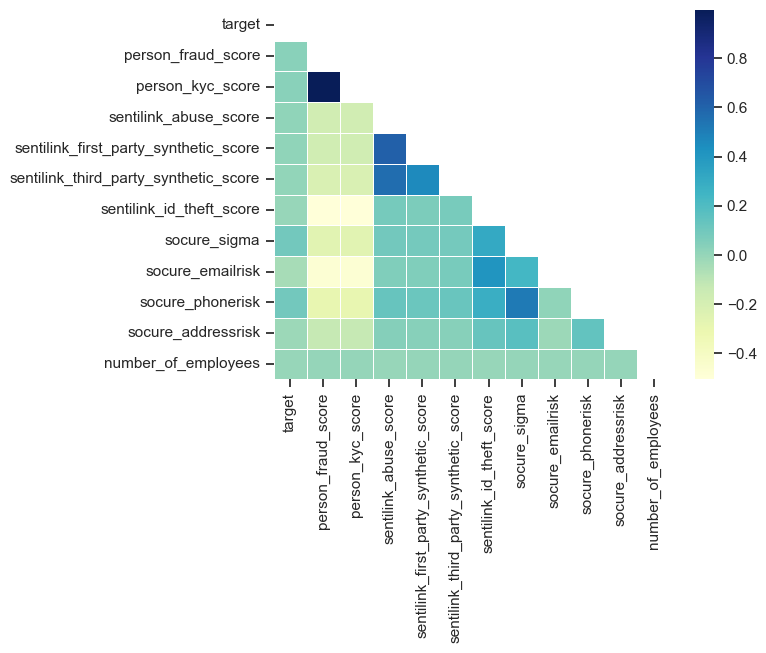

In [18]:
# applying mask 
mask = np.triu(np.ones_like(df[['target']+num_cols].corr(), dtype=bool))
# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
htmap = sns.heatmap(df[['target']+num_cols].corr(method='pearson'), cmap="YlGnBu", annot=True, fmt='.2f', linewidths=.5, mask=mask)
plt.show()

#### Numerical columns - Univariate Plots

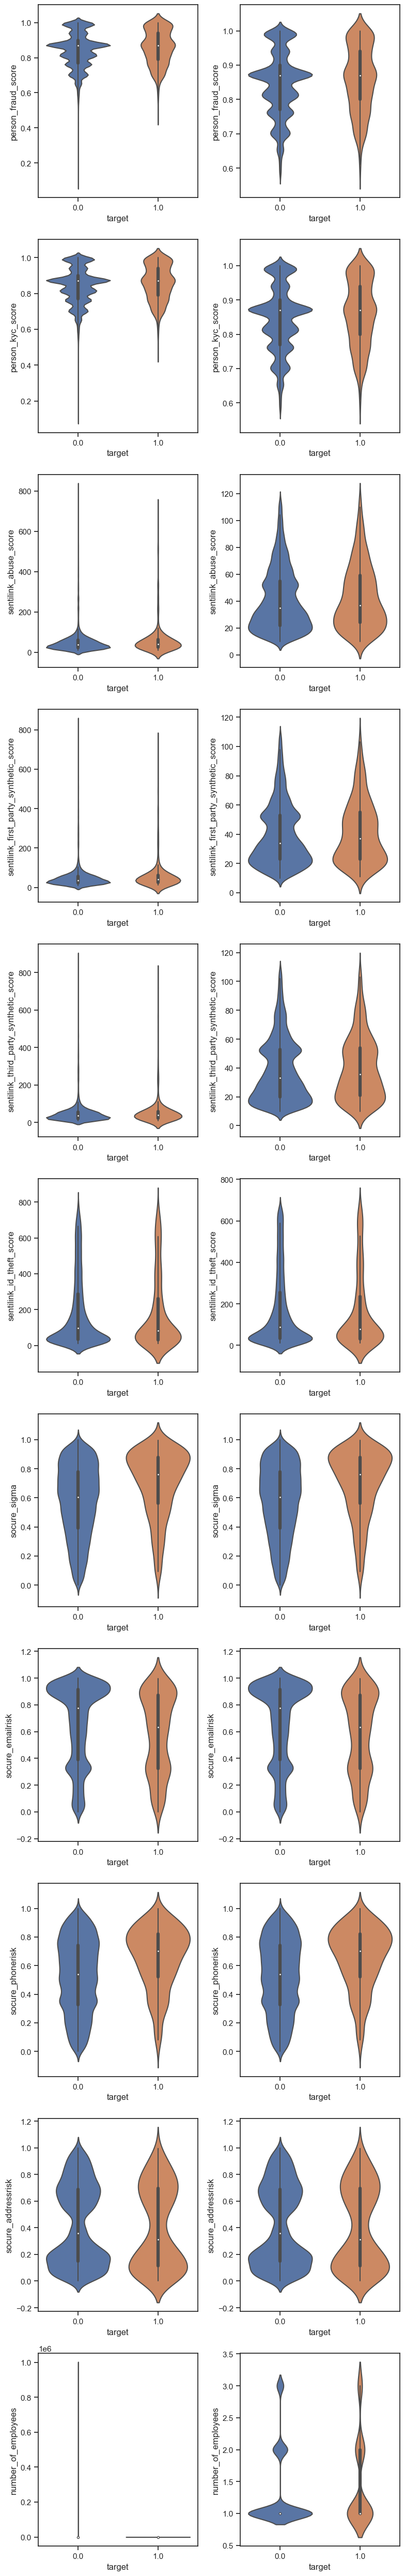

In [19]:
hue_col = 'target'

f, axes = plt.subplots(len(num_cols),2, figsize=(8, 50), sharex=False)
for i, col in enumerate(num_cols):
    sns.violinplot(y=col, x=hue_col, orient='v', data=df, ax=axes[i,0])
    
    # Capping upper and lower limits using IQR whiskers
    upper_limit = float(df[col].quantile([0.75]).values + 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
    lower_limit = float(df[col].quantile([0.25]).values - 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
    df_tmp = df[(df[col]<=upper_limit) & (df[col]>=lower_limit)].reset_index(drop=True)
    
    sns.violinplot(y=col, x=hue_col, orient='v', data=df_tmp, ax=axes[i,1])
    
plt.tight_layout()


From the above correlation matrix and charts, socure_sigma and socure_phonerisk has the highest correlation with the fraud behaviour while socure_emailrisk and number_of_employees has relatively moderate correlation.

### Date and Time Features

#### application_start_date and application_complete_date

In [20]:
# Filling nulls with the start date because the difference between start date and complete date remains less than 24 hours
df['application_complete_datetime'] = np.where(df['application_complete_datetime'].isnull(), df['application_start_datetime'], 
                                               df['application_complete_datetime'])
df['application_start_datetime'] = pd.to_datetime(df['application_start_datetime'])
df['application_complete_datetime'] = pd.to_datetime(df['application_complete_datetime'])

In [21]:

# Function to convert day of month to the week of month
def weekofmonth(val):
    if val<=7:
        return 1
    elif val<=14:
        return 2
    elif val<=21:
        return 3
    else:
        return 4

def weekdaytonumber(val):
    val = val.lower()
    if val=='monday':
        return 1
    elif val=='tuesday':
        return 2
    elif val=='wednesday':
        return 3
    elif val=='thursday':
        return 4
    elif val=='friday':
        return 5
    elif val=='saturday':
        return 6
    elif val=='sunday':
        return 0
    else:
        return None


# App start date features
df['app_start_monthofyear'] = df['application_start_datetime'].dt.month
df['app_start_dateofmonth'] = df['application_start_datetime'].dt.day
df['app_start_weekofmonth'] = df['app_start_dateofmonth'].apply(weekofmonth)
df['app_start_dayofweek'] = df['application_start_datetime'].dt.day_name()
df['app_start_dayofweek'] = df['app_start_dayofweek'].astype('string').apply(weekdaytonumber)
df['app_start_hourofday'] = df['application_start_datetime'].dt.hour

# App complete date features
df['app_complete_monthofyear'] = df['application_complete_datetime'].dt.month
df['app_complete_dateofmonth'] = df['application_complete_datetime'].dt.day
df['app_complete_weekofmonth'] = df['app_complete_dateofmonth'].apply(weekofmonth)
df['app_complete_dayofweek'] = df['application_complete_datetime'].dt.day_name()
df['app_complete_dayofweek'] = df['app_complete_dayofweek'].astype('string').apply(weekdaytonumber)
df['app_complete_hourofday'] = df['application_complete_datetime'].dt.hour


In [22]:
time_features = ['app_start_monthofyear', 'app_start_dateofmonth', 'app_start_weekofmonth', 'app_start_dayofweek', 'app_start_hourofday'
         ,'app_complete_monthofyear', 'app_complete_dateofmonth', 'app_complete_weekofmonth', 'app_complete_dayofweek', 'app_complete_hourofday']


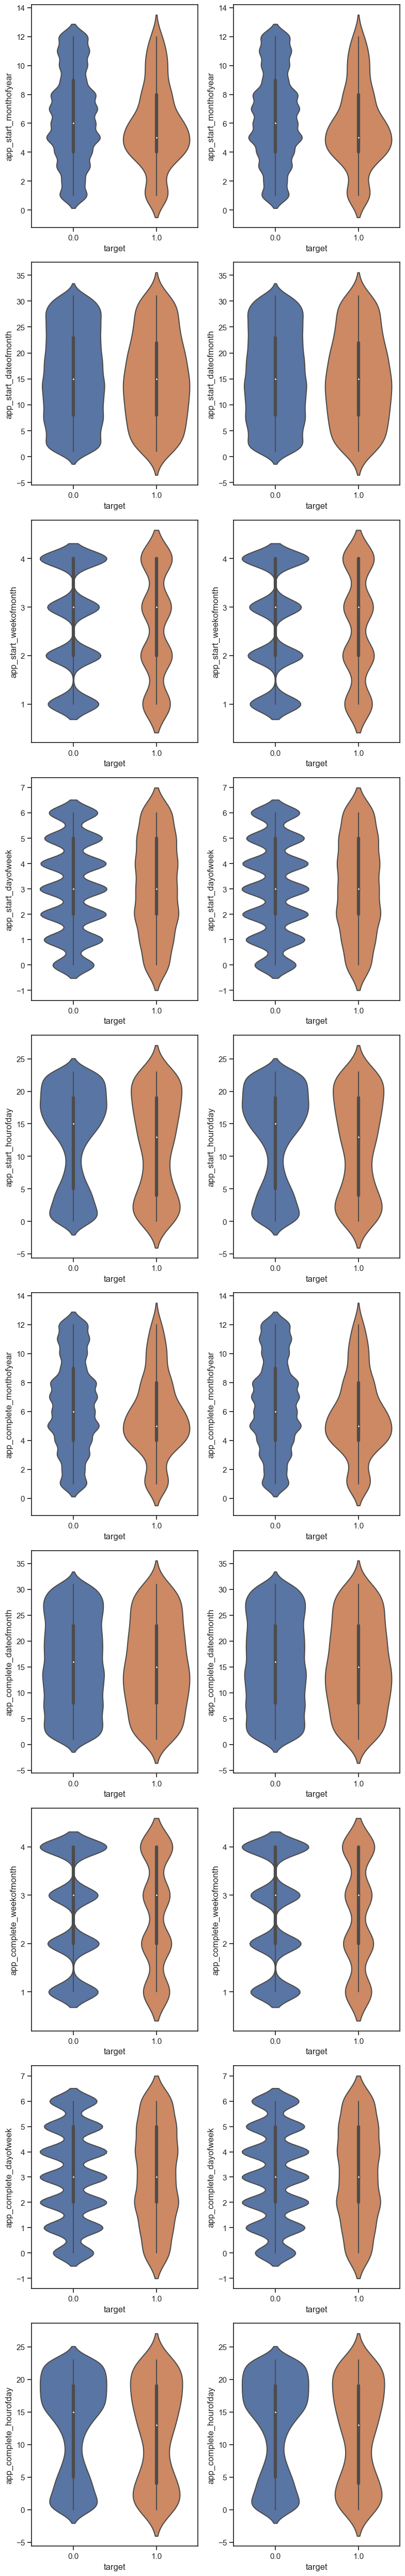

In [23]:
hue_col = 'target'

f, axes = plt.subplots(len(time_features),2, figsize=(8, 50), sharex=False)
for i, col in enumerate(time_features):
    sns.violinplot(y=col, x=hue_col, orient='v', data=df, ax=axes[i,0])
    
    # Capping upper and lower limits using IQR whiskers
    upper_limit = float(df[col].quantile([0.75]).values + 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
    lower_limit = float(df[col].quantile([0.25]).values - 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
    df_tmp = df[(df[col]<=upper_limit) & (df[col]>=lower_limit)].reset_index(drop=True)
    
    sns.violinplot(y=col, x=hue_col, orient='v', data=df_tmp, ax=axes[i,1])
    
plt.tight_layout()


In [24]:
# Checking ordinal correlation
df[['target']+time_features].corr(method='spearman')

target  app_start_monthofyear  \
target                    1.000000              -0.039260   
app_start_monthofyear    -0.039260               1.000000   
app_start_dateofmonth    -0.009494              -0.023627   
app_start_weekofmonth    -0.010488              -0.024811   
app_start_dayofweek       0.005560               0.002653   
app_start_hourofday      -0.026195              -0.020293   
app_complete_monthofyear -0.045239               0.961631   
app_complete_dateofmonth -0.008398              -0.021760   
app_complete_weekofmonth -0.008682              -0.023873   
app_complete_dayofweek    0.005835               0.008482   
app_complete_hourofday   -0.027511              -0.021613   

                          app_start_dateofmonth  app_start_weekofmonth  \
target                                -0.009494              -0.010488   
app_start_monthofyear                 -0.023627              -0.024811   
app_start_dateofmonth                  1.000000               0.967522   
app_start_weekofmonth                  0.967522               1.000000   
app_start_dayofweek                   -0.036315              -0.028194   
app_start_hourofday                   -0.009768              -0.012365   
app_complete_monthofyear              -0.019774              -0.020744   
app_complete_dateofmonth               0.879550               0.853376   
app_complete_weekofmonth               0.854595               0.883976   
app_complete_dayofweek                -0.025745              -0.017828   
app_complete_hourofday                -0.005899              -0.008214   

                          app_start_dayofweek  app_start_hourofday  \
target                               0.005560            -0.026195   
app_start_monthofyear                0.002653            -0.020293   
app_start_dateofmonth               -0.036315            -0.009768   
app_start_weekofmonth               -0.028194            -0.012365   
app_start_dayofweek                  1.000000            -0.043285   
app_start_hourofday                 -0.043285             1.000000   
app_complete_monthofyear             0.003907            -0.020721   
app_complete_dateofmonth            -0.028786            -0.002889   
app_complete_weekofmonth            -0.020184            -0.005482   
app_complete_dayofweek               0.839885            -0.034084   
app_complete_hourofday              -0.039798             0.742421   

                          app_complete_monthofyear  app_complete_dateofmonth  \
target                                   -0.045239                 -0.008398   
app_start_monthofyear                     0.961631                 -0.021760   
app_start_dateofmonth                    -0.019774                  0.879550   
app_start_weekofmonth                    -0.020744                  0.853376   
app_start_dayofweek                       0.003907                 -0.028786   
app_start_hourofday                      -0.020721                 -0.002889   
app_complete_monthofyear                  1.000000                 -0.030131   
app_complete_dateofmonth                 -0.030131                  1.000000   
app_complete_weekofmonth                 -0.032005                  0.966957   
app_complete_dayofweek                    0.008583                 -0.031433   
app_complete_hourofday                   -0.022463                 -0.012466   

                          app_complete_weekofmonth  app_complete_dayofweek  \
target                                   -0.008682                0.005835   
app_start_monthofyear                    -0.023873                0.008482   
app_start_dateofmonth                     0.854595               -0.025745   
app_start_weekofmonth                     0.883976               -0.017828   
app_start_dayofweek                      -0.020184                0.839885   
app_start_hourofday                      -0.005482               -0.034084   
app_complete_monthofyear                 -0.032005        

None of the above features are good enough to predict the fraud behaviour.

### Categorical data

In [25]:
df_tmp = df.copy(deep=True)

#### iovation_device_type

In [26]:
col = 'iovation_device_type'
df[col] = df[col].str.lower()
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

iovation_device_type  count  target  target_rate   percent
4               iphone   8682   378.0     0.043538  0.439840
0              android   5237   313.0     0.059767  0.265312
8              windows   2993    36.0     0.012028  0.151629
7                  mac   2362    13.0     0.005504  0.119662
1             chromeos    270     6.0     0.022222  0.013679
3                 ipad    102     2.0     0.019608  0.005167
6                linux     88     2.0     0.022727  0.004458
2       handheld_other      4     1.0     0.250000  0.000203
5                 ipod      1     0.0     0.000000  0.000051

In [27]:
df[col] = df[col].str.lower()
df[col] = np.where(df[col].isin(['iphone', 'mac','ipad', 'ipod']), 'apple', df[col])
df[col] = np.where(df[col].isin(['chromeos', 'linux', 'handheld_other']), 'other', df[col])

In [28]:
df[col] = df[col].str.lower()
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

iovation_device_type  count  target  target_rate   percent
1                apple  11147   393.0     0.035256  0.564720
0              android   5237   313.0     0.059767  0.265312
3              windows   2993    36.0     0.012028  0.151629
2                other    362     9.0     0.024862  0.018339

#### Estimated Features

In [29]:
accounts_cols = ['estimated_monthly_revenue','incoming_ach_payments','check_deposit_amount'
                 ,'incoming_wire_transfer','outgoing_ach_and_checks','outgoing_wire_transfers']

In [30]:
# Correcting the features values to standard format
def func(value):
    if value == None:
        return None
    value = value.lower()
    if value == '$0':
        return '0k'
    elif value  in ['$0 - $1k', '<$1k']:
        return '1k'
    elif value  == '$1k +':
        return '1k_plus'
    elif value  == '$5k +':
        return '5k_plus'
    elif value  == '$50k +':
        return '50k_plus'
    else:
        return value

for col in accounts_cols:
    df[col] = df[col].apply(func)
    tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                                 'mean':'target_rate'})
    tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
    tmp = tmp1.merge(tmp2, on=col, how='inner')
    print(tmp)
    print('\n\n')

  estimated_monthly_revenue  count  target  target_rate   percent
0                        0k    627    11.0     0.017544  0.030394
1                        1k   5935   126.0     0.021230  0.287702
2                   1k_plus   6998   256.0     0.036582  0.339231
3                  50k_plus    979    51.0     0.052094  0.047457
4                   5k_plus   6090   321.0     0.052709  0.295215



  incoming_ach_payments  count  target  target_rate   percent
0                    0k   2579    57.0     0.022102  0.125018
1                    1k   7456   200.0     0.026824  0.361433
2               1k_plus   5642   235.0     0.041652  0.273498
3              50k_plus    825    41.0     0.049697  0.039992
4               5k_plus   4127   232.0     0.056215  0.200058



  check_deposit_amount  count  target  target_rate   percent
0                   0k   3527    84.0     0.023816  0.170973
1                   1k   7254   199.0     0.027433  0.351641
2              1k_plus   4907   231.0     0

All the above estimated features has a lower fraud rate for 0k & 1k and higher fraud rate for the rest.

So, the features are divided into two groups: upto_1k and 1k_plus

In [31]:
# Grouping the features values to the observed variance
def func(value):
    if value == None:
        return None
    value = value.lower()
    if value in ['0k', '1k']:
        return 'upto_1k'
    elif value in ['1k_plus', '5k_plus', '50k_plus']:
        return '1k_plus'
    else:
        return value

for col in accounts_cols:
    df[col] = df[col].apply(func)
    tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                                 'mean':'target_rate'})
    tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
    tmp = tmp1.merge(tmp2, on=col, how='inner')
    print(tmp)
    print('\n\n')

  estimated_monthly_revenue  count  target  target_rate   percent
0                   1k_plus  14067   628.0     0.044643  0.681904
1                   upto_1k   6562   137.0     0.020878  0.318096



  incoming_ach_payments  count  target  target_rate   percent
0               1k_plus  10594   508.0     0.047952  0.513549
1               upto_1k  10035   257.0     0.025610  0.486451



  check_deposit_amount  count  target  target_rate   percent
0              1k_plus   9848   482.0     0.048944  0.477386
1              upto_1k  10781   283.0     0.026250  0.522614



  incoming_wire_transfer  count  target  target_rate  percent
0                1k_plus   6835   367.0     0.053694  0.33133
1                upto_1k  13794   398.0     0.028853  0.66867



  outgoing_ach_and_checks  count  target  target_rate   percent
0                 1k_plus   8184   427.0     0.052175  0.396723
1                 upto_1k  12445   338.0     0.027160  0.603277



  outgoing_wire_transfers  count  target

#### line_type

In [32]:
col = 'line_type'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                                 'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'])

line_type  count  target  target_rate   percent
0      Fixed VOIP      2     0.0     0.000000  0.000097
5        Tollfree      4     0.0     0.000000  0.000195
4         Premium      5     0.0     0.000000  0.000243
1        Landline      6     0.0     0.000000  0.000292
3  Non-fixed VOIP    922    46.0     0.049892  0.044833
2          Mobile  19626   715.0     0.036431  0.954340

The fraud variance between the top variables are not enough to consider it for the modelling. Also, the top value frequency is more than 95%.

#### industry_category_name

In [33]:
col = 'industry_category_name'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                                 'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'])

industry_category_name  count  target  \
17                                          Utilities     18     2.0   
13                              Public Administration     27     1.0   
10                                             Mining     29     2.0   
6                               Finance and Insurance    191     9.0   
2          Agriculture, Forestry, Fishing and Hunting    230    13.0   
14                     Real Estate Rental and Leasing    345     8.0   
5                                Educational Services    472    13.0   
18                                    Wholesale Trade    509    27.0   
8                                         Information    581    10.0   
16                     Transportation and Warehousing    602    15.0   
7                   Health Care and Social Assistance    771    31.0   
4                                        Construction   1112    53.0   
3                 Arts, Entertainment, and Recreation   1240    37.0   
9                                       Manufacturing   1467    56.0   
0                     Accommodation and Food Services   1962   101.0   
11                                     Other Services   2208    93.0   
12   Professional, Scientific, and Technical Services   2217    41.0   
15                                       Retail Trade   3156    86.0   
1   Administrative and Support and Waste Managemen...   3492   167.0   

    target_rate   percent  
17     0.111111  0.000873  
13     0.037037  0.001309  
10     0.068966  0.001406  
6      0.047120  0.009259  
2      0.056522  0.011149  
14     0.023188  0.016724  
5      0.027542  0.022880  
18     0.053045  0.024674  
8      0.017212  0.028164  
16     0.024917  0.029182  
7      0.040208  0.037375  
4      0.047662  0.053905  
3      0.029839  0.060110  
9      0.038173  0.071113  
0      0.051478  0.095109  
11     0.042120  0.107034  
12     0.018493  0.107470  
15     0.027250  0.152989  
1      0.047824  0.169276

In [34]:
df[col] = df[col].str.lower()
df[col] = np.where(df[col].isin(['utilities','mining', 'agriculture, forestry, fishing and hunting', 'wholesale trade', 
                                 'accommodation and food services', 'administrative and support and waste management and remediation services',
                                 'construction', 'finance and insurance', 'mining', 'other services', 'health care and social assistance',
                                'manufacturing', 'public administration']), 'cat1', 'cat2')

In [35]:
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                                 'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'])

industry_category_name  count  target  target_rate   percent
1                   cat2   8613   210.0     0.024382  0.417519
0                   cat1  12016   555.0     0.046188  0.582481

Converting the industry category into two groups basis the target rate.

has_international_business

In [36]:
col = 'has_international_business'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                                 'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'])

has_international_business  count  target  target_rate   percent
1                        True    536    11.0     0.020522  0.025983
0                       False  20093   754.0     0.037526  0.974017

97% of the feature has only one value and doesn't hold good variance to predict the target.

In [37]:

# rejected_cols = []
# accepted_cols = []
# for col in cat_columns:
#     CrosstabResult=pd.crosstab(index=df[col],columns=df['target'])
#     stat, p, dof, expected = chi2_contingency(CrosstabResult)
#     # interpret p-value
#     alpha = 0.05
#     # print("p value is " + str(p))
#     if p <= alpha:
#         accepted_cols.append(col)
#         # print(col, ': Dependent (reject H0)')
#     else:
#         rejected_cols.append(col)
#         # print(col, ': Independent (H0 holds true)')
#     # print('\n\n')

In [38]:
# device_match_flag, email_name_flag, company_name_email_flag, 

### High Cardinality Features

In [39]:
high_cardinality_columns

['iovation_device_timezone',
 'iovation_device_ip',
 'iovation_device_ip_isp',
 'iovation_device_ip_org',
 'iovation_device_ip_city',
 'iovation_device_ip_region',
 'carrier',
 'email',
 'email_domain',
 'industry_name',
 'website',
 'business_address_city',
 'business_address_state',
 'industry_category_from_pitch',
 'company_name',
 'iovation_device_timezone']

iovation_device_timezone

In [40]:
col = 'iovation_device_timezone'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

iovation_device_timezone  count  target  target_rate   percent
13                     300.0   9024   332.0     0.036791  0.457166
14                     360.0   6456   305.0     0.047243  0.327068
16                     480.0   3121    79.0     0.025312  0.158113
15                     420.0    945    31.0     0.032804  0.047875
18                     600.0     53     1.0     0.018868  0.002685
9                      -60.0     35     0.0     0.000000  0.001773
12                     240.0     28     1.0     0.035714  0.001419
17                     540.0     26     0.0     0.000000  0.001317
3                     -480.0     17     2.0     0.117647  0.000861
8                     -120.0      7     0.0     0.000000  0.000355
4                     -420.0      6     0.0     0.000000  0.000304
10                       0.0      5     0.0     0.000000  0.000253
2                     -540.0      5     0.0     0.000000  0.000253
11                     180.0      4     0.0     0.000000  0.000203
6                     -240.0      2     0.0     0.000000  0.000101
5                     -330.0      2     0.0     0.000000  0.000101
7                     -180.0      1     0.0     0.000000  0.000051
1                     -600.0      1     0.0     0.000000  0.000051
0                     -720.0      1     0.0     0.000000  0.000051

In [41]:

idx_1 = df.index[df[col].isin([300,360,480])].tolist() 
# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()
# other has ~5% of fraud 
idx_other = list(set(idx_full) - set(idx_1) - set(idx_nulls)) 


In [42]:
# Filling other indexes with 'other'
df.loc[idx_other, col] = 'other'
sum(df[(df[col].isin(['other']))].groupby(col)['target'].sum())/df.target.sum()

0.0457516339869281

In [43]:
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

iovation_device_timezone  count  target  target_rate   percent
0                    300.0   9024   332.0     0.036791  0.457166
1                    360.0   6456   305.0     0.047243  0.327068
2                    480.0   3121    79.0     0.025312  0.158113
3                    other   1138    35.0     0.030756  0.057652

email_domain

In [44]:
col = 'email_domain'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')

pd.options.display.max_rows=3000
tmp.sort_values(by=['percent'], ascending=False)

email_domain  count  target  target_rate   percent
863                           gmail.com  14394   587.0     0.040781  0.697756
2588                          yahoo.com   1668    75.0     0.044964  0.080857
1022                         icloud.com    733    46.0     0.062756  0.035533
1674                        outlook.com    447    17.0     0.038031  0.021669
994                         hotmail.com    211     8.0     0.037915  0.010228
146                             aol.com    151     3.0     0.019868  0.007320
1806                     protonmail.com     73     1.0     0.013699  0.003539
1319                           live.com     52     0.0     0.000000  0.002521
1382                           mail.com     44     2.0     0.045455  0.002133
1805                          proton.me     37     1.0     0.027027  0.001794
1436                             me.com     30     0.0     0.000000  0.001454
474                         comcast.net     29     0.0     0.000000  0.001406
2594                          ymail.com     25     1.0     0.040000  0.001212
1915                     rocketmail.com     14     1.0     0.071429  0.000679
1524                            msn.com     13     1.0     0.076923  0.000630
181                             att.net     13     0.0     0.000000  0.000630
1559                        myyahoo.com     12     0.0     0.000000  0.000582
1750                              pm.me      9     0.0     0.000000  0.000436
1971                      sbcglobal.net      9     0.0     0.000000  0.000436
1612                            novo.co      9     0.0     0.000000  0.000436
865                             gmx.com      8     1.0     0.125000  0.000388
1534                     my.strayer.edu      6     0.0     0.000000  0.000291
1232                             kw.com      5     0.0     0.000000  0.000242
78                              aim.com      4     1.0     0.250000  0.000194
2368                      tophotmail.us      4     0.0     0.000000  0.000194
671                           email.com      4     0.0     0.000000  0.000194
2611                       zohomail.com      4     0.0     0.000000  0.000194
618                  dreamvacations.com      3     0.0     0.000000  0.000145
1362                            mac.com      3     0.0     0.000000  0.000145
2468                        verizon.net      3     0.0     0.000000  0.000145
629                            duck.com      3     0.0     0.000000  0.000145
2443                            usa.com      3     0.0     0.000000  0.000145
408                         charter.net      3     0.0     0.000000  0.000145
244                       bellsouth.net      3     0.0     0.000000  0.000145
2422                        ubercom.pro      3     0.0     0.000000  0.000145
726                       exprealty.com      2     0.0     0.000000  0.000097
1531                             my.com      2     0.0     0.000000  0.000097
2086                           snhu.edu      2     0.0     0.000000  0.000097
1580               neuropathyglobal.com      2     0.0     0.000000  0.000097
1579                        netzero.net      2     0.0     0.000000  0.000097
2171              student.aiuonline.edu      2     0.0     0.000000  0.000097
2344         thirdeyetherapychicago.com      2     0.0     0.000000  0.000097
1552                         myself.com      2     0.0     0.000000  0.000097
807                        frontier.com      2     0.0     0.000000  0.000097
903                   growdigitalco.com      2     0.0     0.000000  0.000097
1243                         lafilm.edu      2     0.0     0.000000  0.000097
1404                       maricopa.edu      2     0.0     0.000000  0.000097
2100                     solution4u.com      2     0.0     0.000000  0.000097
1940                    rubixscubes.com      2     0.0     0.000000  0.000097
2453                       valdosta.edu      2     1.0     0.500000  0.000097
1625                            nyu.edu      2   

In [45]:

l1 = ['gmail.com']
l2 = ['yahoo.com','outlook.com','icloud.com','hotmail.com','aol.com','protonmail.com']

df[col] = df[col].str.lower()
idx_1 = df.index[df[col].isin(l1)].tolist() 
idx_2 = df.index[df[col].isin(l2)].tolist() 

# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()
# other ~4% of the fraud
idx_other = list(set(idx_full) - set(idx_1+idx_2) - set(idx_nulls))


In [46]:
df.loc[idx_1, col] = 'l1'
df.loc[idx_2, col] = 'l2'
df.loc[idx_other, col] = 'other'

sum(df[(df[col].isin(['other']))].groupby(col)['target'].sum())/df.target.sum()

0.036601307189542485

In [47]:
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

email_domain  count  target  target_rate   percent
0           l1  14394   587.0     0.040781  0.697756
1           l2   3283   150.0     0.045690  0.159145
2        other   2952    28.0     0.009485  0.143100

Email Domain has good variance with one of the categories.

iovation_device_ip_isp

In [48]:
col = 'iovation_device_ip_isp'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')

In [49]:
# sum(tmp[tmp.percent>=0.02].sort_values(by=['percent'], ascending=False)['percent'])
tmp[tmp.percent>=0.02].sort_values(by=['percent'], ascending=False)


iovation_device_ip_isp  count  target  target_rate   percent
171                     COMCAST   3847   129.0     0.033533  0.187056
662          T-MOBILE USA  INC.   2715   115.0     0.042357  0.132014
63             ATT SERVICES INC   2705   110.0     0.040665  0.131528
135  CHARTER COMMUNICATIONS INC   2151    68.0     0.031613  0.104590
759                     VERIZON   2120    86.0     0.040566  0.103083
133      CHARTER COMMUNICATIONS    908    38.0     0.041850  0.044151
191     COX COMMUNICATIONS INC.    820    23.0     0.028049  0.039872
57            AT&T MOBILITY LLC    590    28.0     0.047458  0.028688

In [50]:
df[col] = df[col].str.lower()
idx_tmobile = df.index[df[col].str.contains('t-mobile')==True].tolist() 
idx_verizon = df.index[df[col].str.contains('verizon')==True].tolist() 
idx_att = df.index[df[col].str.contains('at&t')==True].tolist() 
idx_att.extend(df.index[df[col].str.match('att')==True].tolist())
idx_att = list(set(idx_att))
idx_charter = df.index[df[col].str.match('charter [b|c]')==True].tolist() 
idx_comcast = df.index[df[col].str.match('comcast')==True].tolist() 
idx_cox = df.index[df[col].str.match('cox c')==True].tolist()

# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()
# other has ~20% fraud
idx_other = list(set(idx_full) - 
                 set(idx_att + idx_charter + idx_tmobile + idx_verizon + idx_comcast + idx_cox) - set(idx_nulls))

In [51]:
df.loc[idx_att, col] = 'at&t'
df.loc[idx_tmobile, col] = 't-mobile'
df.loc[idx_charter, col] = 'charter'
df.loc[idx_verizon, col] = 'verizon'
df.loc[idx_comcast, col] = 'comcast'
df.loc[idx_cox, col] = 'cox'
df.loc[idx_other, col] = 'other'

sum(df[~(df[col].isin(['other']))].groupby(col)['target'].sum())/df.target.sum()

0.7973856209150327

In [52]:
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

iovation_device_ip_isp  count  target  target_rate   percent
4                  other   4261   152.0     0.035672  0.207187
2                comcast   3848   129.0     0.033524  0.187105
1                charter   3415   119.0     0.034846  0.166051
0                   at&t   3297   138.0     0.041856  0.160313
5               t-mobile   2715   115.0     0.042357  0.132014
6                verizon   2210    86.0     0.038914  0.107459
3                    cox    820    23.0     0.028049  0.039872

This feature doesn't hold good variance to predict the target

iovation_device_ip_org

In [53]:
col = 'iovation_device_ip_org'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

iovation_device_ip_org  count  target  \
273                                             COMCAST   3836   129.0   
1056                                           T-MOBILE   2715   115.0   
227                          CHARTER COMMUNICATIONS INC   2243    67.0   
1179                                            VERIZON   2194    86.0   
100                                          AT&T CORP.   1774    71.0   
103                                   AT&T MOBILITY LLC   1132    49.0   
225                              CHARTER COMMUNICATIONS    964    41.0   
295                                  COX COMMUNICATIONS    462    14.0   
296                             COX COMMUNICATIONS INC.    355     9.0   
970                        SERVICE PROVIDER CORPORATION    314    21.0   
220                     CENTURYLINK COMMUNICATIONS  LLC    297    11.0   
256                                    CLOUDFLARE  INC.    242     7.0   
806                OPTIMUM ONLINE (CABLEVISION SYSTEMS)    240     7.0   
424                             FRONTIER COMMUNICATIONS    232    10.0   
1040                          SUDDENLINK COMMUNICATIONS    193     7.0   
673                        MEDIACOM COMMUNICATIONS CORP    157     4.0   
42                            AKAMAI TECHNOLOGIES  INC.    140     6.0   
1224                          WINDSTREAM COMMUNICATIONS    136    12.0   
451                                              GOOGLE     92     1.0   
1219                               WIDEOPENWEST FINANCE     88     2.0   
226                         CHARTER COMMUNICATIONS  INC     82     7.0   
189                                     CABLE ONE  INC.     73     1.0   
904                                        PSINET  INC.     52     2.0   
920                                                 RCN     46     0.0   
819                                      PACKETHUB S.A.     38     1.0   
1071                                        TDS TELECOM     32     4.0   
525                              HUGHES NETWORK SYSTEMS     32     0.0   
106                                  ATLANTIC BROADBAND     30     2.0   
700                         MIDCONTINENT COMMUNICATIONS     27     1.0   
897                                    PRIVATE CUSTOMER     27     1.0   
427                                FUSE INTERNET ACCESS     24     1.0   
1182                                        VIASAT INC.     24     0.0   
1251                                      ZSCALER  INC.     23     0.0   
1247                                        ZIPLY FIBER     22     1.0   
71                             AMAZON TECHNOLOGIES INC.     22     2.0   
837                           PENTELEDATA HOUSE ACCOUNT     21     2.0   
184                                    C SPIRE WIRELESS     20     3.0   
171                     BRIGHTHOUSE NETWORKS BIRMINGHAM     19     1.0   
92                                            ARMSTRONG     17     0.0   
784                     NORTHLAND CABLE TELEVISION INC.     17     1.0   
1000                                     SONIC.NET  LLC     17     0.0   
179                           BUCKEYE CABLEVISION  INC.     16     1.0   
130                       BCI MISSISSIPPI BROADBAND LLC     16     3.0   
1022                                       STARRY  INC.     16     0.0   
616                                 LEVEL 3 PARENT  LLC     15     1.0   
1008                              SPACEX SERVICES  INC.     15     0.0   
435                         GENERAL COMMUNICATION  INC.     15     0.0   
939                         ROCK HILL TELEPHONE COMPANY     13     0.0   
486                  HARGRAY COMMUNICATIONS GROUP  INC.     13     0.0   
188                                           CABLE ONE     13     1.0   
104                                 AT&T SERVICES  INC.     12     0.0   
1006  SOUTHERN NEW ENGLAND TELEPHONE COMPANY AND SNE...     12     1.0   
630                                       LOGICWEB INC.     12     0.0   
172                   BRIGHTHOUSE NET

In [54]:

df[col] = df[col].str.lower()
idx_tmobile = df.index[df[col].str.contains('t-mobile')==True].tolist() 
idx_verizon = df.index[df[col].str.contains('verizon')==True].tolist() 
idx_att = df.index[df[col].str.contains('at&t')==True].tolist() 

idx_att.extend(df.index[df[col].str.match('att')==True].tolist())
idx_att = list(set(idx_att))
idx_charter = df.index[df[col].str.match('charter [b|c]')==True].tolist() 
idx_comcast = df.index[df[col].str.match('comcast')==True].tolist() 
idx_cox = df.index[df[col].str.match('cox c')==True].tolist()


# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()
# other has ~23% fraud
idx_other = list(set(idx_full) - 
                 set(idx_att + idx_charter + idx_tmobile + idx_verizon + idx_comcast + idx_cox) - set(idx_nulls))

In [55]:
df.loc[idx_att, col] = 'at&t'
df.loc[idx_tmobile, col] = 't-mobile'
df.loc[idx_charter, col] = 'charter'
df.loc[idx_verizon, col] = 'verizon'
df.loc[idx_comcast, col] = 'comcast'
df.loc[idx_cox, col] = 'cox'
df.loc[idx_other, col] = 'other'

sum(df[~(df[col].isin(['other']))].groupby(col)['target'].sum())/df.target.sum()

0.7686274509803922

In [56]:
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

iovation_device_ip_org  count  target  target_rate   percent
4                  other   4713   173.0     0.036707  0.229925
2                comcast   3836   129.0     0.033629  0.187140
1                charter   3290   115.0     0.034954  0.160503
0                   at&t   2933   120.0     0.040914  0.143087
5               t-mobile   2715   115.0     0.042357  0.132452
6                verizon   2194    86.0     0.039198  0.107035
3                    cox    817    23.0     0.028152  0.039858

This feature doesn't hold good variance to predict the target

carrier

In [57]:
col = 'carrier'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

carrier  count  target  \
39                                      T-Mobile USA   6453   242.0   
50                                  Verizon Wireless   5857   206.0   
0                                               AT&T   4067   128.0   
38                                          T-Mobile   1612    66.0   
18                                  Cricket Wireless    941    36.0   
40                   T-Mobile USA (form. Metro PCS )    439    22.0   
24                                      Google Voice    421    17.0   
44                                           TextNow    325    11.0   
47                                       US Cellular    147     5.0   
28                                    Onvoy Spectrum     78    14.0   
15                                    Cellular South     53     5.0   
11                                      CSC Wireless     14     1.0   
5                                       Bandwidth/19     13     0.0   
3                                       Bandwidth/13     12     0.0   
46                                            Twilio     11     0.0   
22                                          GoTextMe      9     1.0   
9                                       Boost Mobile      9     1.0   
45                                          TextPlus      9     0.0   
31                                            Pinger      8     2.0   
42                                      T-Mobile Usa      6     0.0   
29                                           Onvoy/3      6     0.0   
21                          GCI Communications Corp.      6     0.0   
17                                 Claro Puerto Rico      5     0.0   
34                                 Republic Wireless      5     0.0   
4                                       Bandwidth/15      4     0.0   
14                                           Cellcom      4     0.0   
37                                            Sprint      4     1.0   
35                                             Skype      3     0.0   
6                                       Bandwidth/20      3     0.0   
20                           GCI Communication Corp.      3     0.0   
7                                        Bandwidth/9      3     1.0   
13                            Carolina West Wireless      3     0.0   
51     Viaero Wireless (fka N.E. Colorado Cellular )      3     0.0   
8                    Bandwidth/RingCentral Messaging      3     0.0   
30                                           Onvoy/5      2     0.0   
2                                     Bandwidth Test      2     0.0   
41                                T-Mobile USA, Inc.      1     0.0   
43                               Telefinity/teli.net      1     0.0   
49                                 United Tel. Assn.      1     0.0   
52                                 Vitelcom Cellular      1     0.0   
48                           Union Telephone Company      1     1.0   
27                                 Nex-Tech Wireless      1     0.0   
36                                      Smith Bagley      1     0.0   
33                                            Remind      1     0.0   
32                         RSA 1 Limited Partnership      1     1.0   
1                                          Bandwidth      1     0.0   
26                                        MediaMinds      1     0.0   
25                          Guam Telephone Authority      1     0.0   
23  Google (Grand Central) BWI - Bandwidth.com - SVR      1     0.0   
19                             East Kentucky Network      1     0.0   
16                                       Centurylink      1     0.0   
12                                      CT Cube L.P.      1     0.0   
10                         Brightlink Communications      1     0.0   
53                               YMax Communications      1     0.0   

    target_rate   percent  
39     0.037502  0.313847  
50     0.035172  0.284860  
0      0.031473  0.197802  
38     0.040943  0.078401  

In [58]:

df[col] = df[col].str.lower()
idx_tmobile = df.index[df[col].str.contains('t-mobile*')==True].tolist() 
idx_verizon = df.index[df[col].str.contains('verizon')==True].tolist() 
idx_att = df.index[df[col].str.contains('at&t')==True].tolist() 

idx_att.extend(df.index[df[col].str.match('att')==True].tolist())
idx_att = list(set(idx_att))
idx_google = df.index[df[col].str.match('google')==True].tolist() 


# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))
idx_full = df.index.to_list()
# other has ~13% fraud
idx_other = list(set(idx_full) - set(idx_att + idx_google + idx_tmobile + idx_verizon) - set(idx_nulls))

In [59]:
df.loc[idx_att, col] = 'at&t'
df.loc[idx_tmobile, col] = 't-mobile'
df.loc[idx_google, col] = 'google'
df.loc[idx_verizon, col] = 'verizon'
df.loc[idx_other, col] = 'other'

sum(df[~(df[col].isin(['other']))].groupby(col)['target'].sum())/df.target.sum()

0.8901960784313725

In [60]:
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

carrier  count  target  target_rate   percent
3  t-mobile   8511   330.0     0.038773  0.413939
4   verizon   5857   206.0     0.035172  0.284860
0      at&t   4067   128.0     0.031473  0.197802
2     other   1704    80.0     0.046948  0.082875
1    google    422    17.0     0.040284  0.020524

### List Features

In [61]:
list_columns

['person_fraud_tags',
 'person_kyc_tags',
 'socure_reason_code',
 'socure_kyc_field_validations',
 'socure_kyc_reason_code',
 'socure_emailrisk_reason_code',
 'socure_phonerisk_reason_code',
 'socure_addressrisk_reason_code',
 'purpose_of_account',
 'touch_point_emails',
 'owner_list']

socure reason codes

In [62]:
socure_cols = ['socure_phonerisk_reason_code','socure_addressrisk_reason_code','socure_emailrisk_reason_code'
              ,'socure_reason_code', 'socure_kyc_reason_code']
df_socure = df[['application_id'] + socure_cols]

In [63]:
# Cleaning the list of reason codes
def clean_socure_strings(x):
    if x != None:
        x = [val.strip("""'|[| |"|,|]""") for val in x.split('\n') if not val.strip("""'|[| |"|,|]""") in ['',None]]
    return x

socure_cols = ['socure_phonerisk_reason_code','socure_addressrisk_reason_code','socure_emailrisk_reason_code','socure_reason_code','socure_kyc_reason_code']
df_socure = df[['application_id','target'] + socure_cols]

# Collecting the cleaned reason codes
for col in socure_cols:
    df_socure[col] = df_socure[col].str.lower()
    df_socure[col] = df_socure[col].apply(clean_socure_strings)
    

In [64]:
socure_cols = ['socure_phonerisk_reason_code','socure_addressrisk_reason_code','socure_emailrisk_reason_code','socure_reason_code','socure_kyc_reason_code']

dict_cols = {}
for col in socure_cols:
    df_socure = df_socure.drop(col, 1).join(df_socure[col].str.join('|').str.get_dummies())
    socure_cols = df_socure.columns[df_socure.columns.str.startswith('socure')].to_list()
    true_cols = list(set(df_socure.columns.to_list()) - set(socure_cols) - set(['application_id','target']))
    new_cols = []
    for col2 in true_cols:
        new_cols.append(col+'_'+col2)
    dict_cols = dict(zip(true_cols, new_cols)) | dict_cols
    df_socure.rename(columns=dict_cols, inplace=True)

df_socure = df_socure.T
df_socure = df_socure[~df_socure.index.duplicated(keep='first')].T

In [65]:
pd.DataFrame(list(set(df_socure.columns) - set(['application_id','target'])
                 ), columns=['feature']).to_pickle(project_path+'models/socure_reason_codes_columns.pkl')

In [66]:
df.shape, df_socure.shape

((20629, 72), (20629, 207))

In [67]:
# pd.options.display.max_rows=300
df = pd.merge(df,df_socure.drop(columns=['target']), on='application_id', how='inner')

socure_kyc_field_validations

In [68]:
df['socure_kyc_field_validations']

0        {\n  "city": 0.99,\n  "dob": 0.99,\n  "firstNa...
1        {\n  "city": 0.99,\n  "dob": 0.99,\n  "firstNa...
2        {\n  "city": 0.99,\n  "dob": 0.99,\n  "firstNa...
3        {\n  "city": 0.99,\n  "dob": 0.99,\n  "firstNa...
4        {\n  "city": 0.99,\n  "dob": 0.99,\n  "firstNa...
                               ...                        
20624    {\n  "city": 0.99,\n  "dob": 0.99,\n  "firstNa...
20625    {\n  "city": 0.99,\n  "dob": 0.99,\n  "firstNa...
20626    {\n  "city": 0.99,\n  "dob": 0.99,\n  "firstNa...
20627    {\n  "city": 0.99,\n  "dob": 0.99,\n  "firstNa...
20628    {\n  "city": 0.99,\n  "dob": 0.99,\n  "firstNa...
Name: socure_kyc_field_validations, Length: 20629, dtype: object

In [69]:
def socure_kyc_field_extraction(val):
    if val==None or val==[] or val=={} or val=='':
        return (None, None, None, None, None, None, None, None, None)
    else:
        val = json.loads(val.lower())
        city = val['city']
        dob = val['dob']
        firstname = val['firstname']
        mobilenumber = val['mobilenumber']
        ssn = val['ssn']
        state = val['state']
        streetaddress = val['streetaddress']
        surname = val['surname']
        zip_val = val['zip']

        return (surname, firstname, dob, mobilenumber, ssn, state, city, streetaddress, zip_val)


In [70]:
socure_kyc_fields_cols = ['socure_kyc_surname_score', 'socure_kyc_firstname_score', 'socure_kyc_dob_score', 'socure_kyc_mobilenumber_score', 
                         'socure_kyc_ssn_score', 'socure_kyc_state_score', 'socure_kyc_city_score', 'socure_kyc_streetaddress_score', 'socure_kyc_zip_score']
df[socure_kyc_fields_cols] = pd.DataFrame(df.socure_kyc_field_validations.apply(socure_kyc_field_extraction).tolist(),index=df.index)

In [71]:
df[socure_kyc_fields_cols]

socure_kyc_surname_score  socure_kyc_firstname_score  \
0                          0.99                        0.99   
1                          0.99                        0.99   
2                          0.99                        0.99   
3                          0.99                        0.99   
4                          0.99                        0.99   
...                         ...                         ...   
20624                      0.99                        0.99   
20625                      0.99                        0.99   
20626                      0.99                        0.99   
20627                      0.99                        0.99   
20628                      0.99                        0.99   

       socure_kyc_dob_score  socure_kyc_mobilenumber_score  \
0                      0.99                           0.99   
1                      0.99                           0.01   
2                      0.99                           0.99   
3                      0.99                           0.01   
4                      0.99                           0.01   
...                     ...                            ...   
20624                  0.99                           0.99   
20625                  0.99                           0.99   
20626                  0.99                           0.01   
20627                  0.99                           0.99   
20628                  0.99                           0.99   

       socure_kyc_ssn_score  socure_kyc_state_score  socure_kyc_city_score  \
0                      0.99                    0.99                   0.99   
1                      0.99                    0.99                   0.99   
2                      0.99                    0.99                   0.99   
3                      0.99                    0.99                   0.99   
4                      0.99                    0.99                   0.99   
...                     ...                     ...                    ...   
20624                  0.99                    0.99                   0.99   
20625                  0.99                    0.99                   0.99   
20626                  0.99                    0.99                   0.99   
20627                  0.99                    0.99                   0.99   
20628                  0.99                    0.99                   0.99   

       socure_kyc_streetaddress_score  socure_kyc_zip_score  
0                                0.99                  0.99  
1                                0.99                  0.99  
2                                0.99                  0.99  
3                                0.99                  0.99  
4                                0.99                  0.99  
...                               ...                   ...  
20624                            0.99                  0.99  
20625                            0.99                  0.99  
20626                            0.99                  0.99  
20627                            0.99                  0.99  
20628                            0.99                  0.99  

[20629 rows x 9 columns]

Creating New purpose of account Features

In [72]:
col = 'purpose_of_account'

# There are 5 unique purpose of accounts categories
unique_vals = ['payroll','accounting','operating','travel expenses','business expenses']
# Creating dummies for each unique string
for val in unique_vals:
    new_col = 'purpose_'+val.replace(" ", "_")
    df[new_col] = 0
    idx = df.index[df[col].str.contains(val)==True].tolist()
    df.loc[idx, new_col] = 1

In [73]:
unique_cols = ['payroll','accounting','operating','travel_expenses','business_expenses']

for i in unique_cols:
    print(df.groupby(['purpose_'+i])['target'].agg(['sum', 'mean']))
    

                   sum      mean
purpose_payroll                 
0                573.0  0.035992
1                192.0  0.040773
                      sum      mean
purpose_accounting                 
0                   404.0  0.041861
1                   361.0  0.032884
                     sum      mean
purpose_operating                 
0                  436.0  0.042244
1                  329.0  0.031917
                           sum      mean
purpose_travel_expenses                 
0                        617.0  0.037969
1                        148.0  0.033798
                             sum      mean
purpose_business_expenses                 
0                          356.0  0.039866
1                          409.0  0.034960


person_fraud_tags

In [74]:
col = 'person_fraud_tags'

In [75]:
df[col][0]

'[\n  "KYC SSN Match",\n  "KYC DOB Match",\n  "KYC Name Match",\n  "KYC: Phone Match",\n  "KYC: Address Match",\n  "Low Fraud Score",\n  "KYC: Online Presence Match"\n]'

In [76]:
df[col][5]

'[\n  "KYC SSN Match",\n  "KYC Name Match",\n  "KYC DOB Match",\n  "KYC: Phone Match",\n  "KYC: Address Match"\n]'

In [77]:
df[col][30]

'[\n  "KYC SSN Match",\n  "KYC Name Match",\n  "KYC DOB Match",\n  "KYC: Address Match",\n  "KYC: Phone Match"\n]'

In [78]:
col = 'person_fraud_tags'
df[col] = df[col].str.lower()
idx_fraud_tags = df.index[df[col].str.contains('not')==True].tolist() # Extrating the indexes where not match string exists

# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))

idx_full = df.index.to_list()
# # other has ~20% fraud
idx_other = list(set(idx_full) - set(idx_fraud_tags) - set(idx_nulls))

In [79]:
col = 'person_fraud_tags_flag'
df[col] = 0 # good data - all match
df.loc[idx_fraud_tags, col] = 1 # at least one of the tags doesn't match 

sum(df[~(df[col]==0)].groupby(col)['target'].sum())/df.target.sum()

0.20392156862745098

In [80]:
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

person_fraud_tags_flag  count  target  target_rate   percent
0                       0  15991   609.0     0.038084  0.775171
1                       1   4638   156.0     0.033635  0.224829

This feature doesn't provide enough variance or power to predict the fraud behaviour.

person_kyc_tags

In [81]:
col = 'person_kyc_tags'

In [82]:
col = 'person_kyc_tags'
df[col] = df[col].str.lower()
idx_kyc_tags = df.index[df[col].str.contains('not')==True].tolist() # Extrating the indexes where not match string exists

# nulls
idx_nulls = df.index[df[col].isnull()].tolist()
idx_nulls.extend(df.index[df[col].isna()].tolist())
idx_nulls.extend(df.index[df[col]==''].tolist())
idx_nulls = list(set(idx_nulls))

idx_full = df.index.to_list()
# # other has ~20% fraud
idx_other = list(set(idx_full) - set(idx_kyc_tags) - set(idx_nulls))

In [83]:
col = 'person_kyc_tags_flag'
df[col] = 0 # good data - all match
df.loc[idx_kyc_tags, col] = 1 # at least one of the tags doesn't match 

sum(df[~(df[col]==0)].groupby(col)['target'].sum())/df.target.sum()

0.20392156862745098

In [84]:
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

person_kyc_tags_flag  count  target  target_rate   percent
0                     0  15991   609.0     0.038084  0.775171
1                     1   4638   156.0     0.033635  0.224829

This feature doesn't provide enough variance or power to predict the fraud behaviour. Also, this is no different from the person_fraud_tags feature.

In [85]:
list_columns

['person_fraud_tags',
 'person_kyc_tags',
 'socure_reason_code',
 'socure_kyc_field_validations',
 'socure_kyc_reason_code',
 'socure_emailrisk_reason_code',
 'socure_phonerisk_reason_code',
 'socure_addressrisk_reason_code',
 'purpose_of_account',
 'touch_point_emails',
 'owner_list']

touch_point_emails

In [86]:
col = 'touch_point_emails'

In [87]:
df[col][0]

'[\n  "started : jeffrey.d.bowman@gmail.com",\n  "completed : jeffrey.d.bowman@gmail.com",\n  "Uploaded_doc : jatin.kalra@novo.co",\n  "Reassigned : jatin.kalra@novo.co",\n  "ready_to_open : jatin.kalra@novo.co",\n  "Reassigned : jatin.kalra@novo.co",\n  "account_setup_in_core : jatin.kalra@novo.co",\n  "Uploaded_doc : pawan@novo.co"\n]'

In [88]:
df[col][30]

'[\n  "started : blazingblinks@gmail.com",\n  "completed : blazingblinks@gmail.com",\n  "Reassigned : sanchita@novo.co",\n  "ready_to_open : sanchita@novo.co",\n  "Reassigned : sanchita@novo.co",\n  "account_setup_in_core : sanchita@novo.co"\n]'

In [89]:
# Cleaning the list of reason codes
def clean_touch_points_email_strings(x):
    if x != None or x!= [] or x!= '':
        x = [val.strip("""'|[| |"|,|]""") for val in x.split('\n') if not val.strip("""'|[| |"|,|]""") in ['',None]]
        started = x[0].split(':')[-1].strip(' ')
        completed = x[1].split(':')[-1].strip(' ')
    else:
        started = None
        completed = None
    return (started, completed)
    

In [90]:
touch_point_email_cols = ['started_app_email', 'completed_app_email']
df[touch_point_email_cols] = pd.DataFrame(df[col].apply(clean_touch_points_email_strings).tolist(),index=df.index)

In [91]:
df[df['started_app_email'] != df['completed_app_email']]

application_id  train_flag  test_flag  \
2      16c28e2e-728f-4b2b-86d8-543a44a1884a         1.0        0.0   
3      21dd7f9b-286a-4956-b8ec-2c45d1024477         1.0        0.0   
24     5fd98bcc-a549-4d19-9c27-70bb8393b095         1.0        0.0   
32     76dcb4c6-619d-4e69-98a3-9fa1ad561684         1.0        0.0   
66     4cacd20f-4c88-4336-b519-f65a078f8e5a         1.0        0.0   
106    e15baa51-44f4-40c7-9af5-653dc88ac9f9         1.0        0.0   
214    35f000fc-87dd-4389-a1a4-bcc9acd91962         1.0        0.0   
221    e42c6ab1-0c66-4ebf-b5b2-9903fcd44399         1.0        0.0   
241    3d3448fc-df2a-4249-93a9-ed642199d20a         1.0        0.0   
341    4fd54982-b2eb-45c8-a67b-120c23c9e885         1.0        0.0   
393    aa17bc87-d6c3-4552-bf61-7faeb71d5db3         1.0        0.0   
429    55005492-032f-4282-9fa6-0e5093c381fa         1.0        0.0   
457    fdf83bea-1dce-46f4-9aa2-d7aa53c734bd         1.0        0.0   
509    824f5a70-a163-4414-991b-9ff17eba7fab         1.0        0.0   
577    042dc313-057c-4414-b2e7-67e51ef8370a         1.0        0.0   
578    991d6af9-f3aa-4f34-8e85-04136e5e50f0         1.0        0.0   
586    f50acfd4-fa50-41c1-aeab-06264fec5dfe         1.0        0.0   
640    147642ea-b1b5-4e06-842e-688b042e0410         1.0        0.0   
641    0cbea9c5-0503-44e2-9642-80c06249633e         1.0        0.0   
663    a1e62fee-680f-49e6-878e-cb8462338ec9         1.0        0.0   
670    104ebc96-2305-409a-938f-7ad06fbe5360         1.0        0.0   
712    1e7886f8-f7e1-4aca-86d4-2f0b57fbcb0a         1.0        0.0   
778    e4f3f6f6-ed0a-49dc-af78-a417e8676007         1.0        0.0   
846    2279beb2-4868-4fd1-80d7-794b4a4cb69d         1.0        0.0   
881    21ba6128-6921-4c18-9372-245433e75b36         1.0        0.0   
884    b47c8457-fe92-4785-ac26-e6f881b6125e         1.0        0.0   
940    7447b644-d241-4ca3-b708-9fb356909cf5         1.0        0.0   
971    8afa478b-025a-4c58-b6b7-409fcbf6c873         1.0        0.0   
985    c679d015-026d-4796-b1ea-183584f1733e         1.0        0.0   
1005   6bf6effc-2dbb-4a64-9074-aef129f3d350         1.0        0.0   
1039   c5450716-a73d-41ca-b98f-2d5e55b41bfb         1.0        0.0   
1071   1d2763a9-eaa4-421a-ab23-de74296431e4         1.0        0.0   
1083   fa479de5-4677-4792-999e-c2a0a847b044         1.0        0.0   
1090   25fec5ad-4462-4593-8a02-a040868528cd         1.0        0.0   
1112   1a980d4c-5d9c-49b3-844a-2092a9f5bf10         1.0        0.0   
1124   033d4b26-2a24-49c3-9bbe-ac5e29a03949         1.0        0.0   
1143   6901850b-9738-4437-8911-68ce796b667c         1.0        0.0   
1172   d0a8db93-d125-4029-91b8-1a8537ebf11a         1.0        0.0   
1203   cd104fc9-2784-49f0-aafd-05c5dedd84c6         1.0        0.0   
1226   4d4dacd1-c4de-4c14-b993-0cfe223d6e95         1.0        0.0   
1276   cc95cf56-efd4-4c71-8c42-270e9d770275         1.0        0.0   
1305   f1d4f679-32fb-48f5-8823-48681a74e8cb         1.0        0.0   
1359   e3a409aa-9511-441e-a742-a76a28a5500e         1.0        0.0   
1383   7869f966-a2de-4ba5-b05b-907bc144a551         1.0        0.0   
1387   0bff7905-1396-4f93-885f-83dded73210b         1.0        0.0   
1389   515b21b1-4b95-4fae-8b27-0cf478a6d1c2         1.0        0.0   
1421   3a7d04a6-9aa6-42c5-a8fa-cbad3bb990db         1.0        0.0   
1461   348628f7-8cfe-46b2-9e36-127750c3ed45         1.0        0.0   
1480   51be22f2-e197-46b1-bfc4-544105561fd8         1.0        0.0   
1522   407f240a-b29b-48ad-bcc8-838a191525e5         1.0        0.0   
1525   56260438-a41f-43df-8b29-739b81ab5720         1.0        0.0   
1627   876155c9-9034-47f7-bb11-d0ef74f2a6cc         1.0        0.0   
1642   200e8e77-08d8-4c4a-85a0-c1a60ab379ab         1.0        0.0   
1652   27a9f0e5-1c0a-48ac-b47a-8d81d67a1832         1.0        0.0   
1659   91e15972-44cb-4de5-839a-774c24c09b0a         1.0        0.0   
1664   35d62635-4182-4b04-a11d-c713219c889a         1.0        0.0   
1675   b5cdd2db-3de7-44e5-82d1-cd6c63cd

In [92]:
# create a started app email and completed app email flag - Done
# match names with started email and completed email flag - Done


In [93]:
df['started_completed_email_flag'] = np.where(df['started_app_email']==df['completed_app_email'],1,0)

In [94]:
col = 'started_completed_email_flag'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

started_completed_email_flag  count  target  target_rate  percent
1                             1  19999   747.0     0.037352  0.96946
0                             0    630    18.0     0.028571  0.03054

email is derived from the completed email. 

owner_list

In [95]:
col = 'owner_list'

In [96]:
# Cleaning the list of reason codes
def clean_owner_list_strings(x):
    x = x.strip("""'|[| |"|,|]""")
    if x != '' :
        try:
            x = [val.strip("""'|[| |"|,|]""") for val in x.split('\n') if not val.strip("""'|[| |"|,|]""") in ['',None,[]]]
            x = ''.join(x[0].split(',')[:-3])
            x = re.sub(r'\s+', ' ', x)
        except:
            return x
    return x

In [97]:
df['ownername'] = df[col].apply(clean_owner_list_strings)

In [98]:
clean_owner_list_strings(df[df.email=='yonnabates@gmail.com']['owner_list'].values[0])

''

In [99]:
df.index[df['email']=='yonnabates@gmail.com'].tolist()

[1775]

In [100]:
def name_matching_with_email(email_id: str, owner_name: str):
    if email_id == None or email_id == '' or owner_name.strip('[|]') == '':
        return (0,0,0)
    # print(email_id)
    email_id = email_id.lower()
    owner_name = owner_name.lower()
    
    email_str1 = re.sub('[0-9]', '',' '.join(email_id.split('@')[0].split('.')))
    if len(email_str1)>=3 :
        name_str1 = [val.strip(' ') for val in re.split(' |-',owner_name) if not val.strip(' ') in ['']]
        permute_list = list(permutations(name_str1))
        max_ratio = 0
        max_partial = 0
        max_token = 0
        name_match_score = 0
        
        for i in range(len(name_str1)):
    
            if len(name_str1[i])>=3 and name_str1[i] in email_id:
                name_match_score = name_match_score + (100/len(name_str1))
            
            permute_str1 = ' '.join(list(permute_list[i]))
            permute_str2 = ''.join(list(permute_list[i]))
            
            score_ratio1 = fuzz.ratio(email_str1, permute_str1)
            score_partial1 = fuzz.partial_ratio(email_str1, permute_str1)
            score_token1 = fuzz.token_sort_ratio(email_str1, permute_str1)
    
            score_ratio2 = fuzz.ratio(email_str1, permute_str2)
            score_partial2 = fuzz.partial_ratio(email_str1, permute_str2)
            score_token2 = fuzz.token_sort_ratio(email_str1, permute_str2)
    
            max_ratio = max([max_ratio, score_ratio1, score_ratio2])
            max_partial = max([max_partial, score_partial1, score_partial2])
            max_token = max([max_token, score_token1, score_token2])
            
            # print(email_id, '\n', email_str1, permute_str1, permute_str2)
            # print('scores:', '\n', score_ratio1, score_ratio2, '\n', score_partial1, score_partial2, '\n', score_token1, score_token2)
            # print('max scores:', max_ratio, max_partial, max_token)
            # print('str_match_score:', name_match_score)
            # print('\n')
    else:
        return (0,0,0)
        
    return (max_ratio, max_partial, name_match_score)

In [101]:
ownername_email_match = ['ownername_email_fuzzy_match_ratio','ownername_email_fuzzy_match', 'ownername_email_substring_match']
df[ownername_email_match] = pd.DataFrame(df.apply(lambda x: name_matching_with_email(x['email'], x['ownername']), axis=1
                                                     ).tolist(),index=df.index)

companyname_email_match = ['companyname_email_fuzzy_match_ratio','companyname_email_fuzzy_match', 'companyname_email_substring_match']
df[companyname_email_match] = pd.DataFrame(df.apply(lambda x: name_matching_with_email(x['email'], x['company_name']), axis=1
                                                     ).tolist(),index=df.index)

In [102]:
df[ownername_email_match+companyname_email_match].describe()

ownername_email_fuzzy_match_ratio  ownername_email_fuzzy_match  \
count                       20629.000000                 20629.000000   
mean                           54.653207                    66.040089   
std                            27.306703                    28.624482   
min                             0.000000                     0.000000   
25%                            31.000000                    40.000000   
50%                            52.000000                    67.000000   
75%                            77.000000                   100.000000   
max                           100.000000                   100.000000   

       ownername_email_substring_match  companyname_email_fuzzy_match_ratio  \
count                     20629.000000                         20629.000000   
mean                         34.263820                            57.334578   
std                          35.783449                            29.040971   
min                           0.000000                             0.000000   
25%                           0.000000                            31.000000   
50%                          33.333333                            56.000000   
75%                          50.000000                            82.000000   
max                         100.000000                           100.000000   

       companyname_email_fuzzy_match  companyname_email_substring_match  
count                   20629.000000                       20629.000000  
mean                       65.933395                          38.866806  
std                        28.925751                          39.854351  
min                         0.000000                           0.000000  
25%                        38.000000                           0.000000  
50%                        67.000000                          50.000000  
75%                       100.000000                          50.000000  
max                       100.000000                         100.000000

In [105]:
# i = 0
# df[ (df.ownername_email_fuzzy_match_ratio>=60) & (df.ownername_email_fuzzy_match>=70)][['application_id','ownername', 'company_name', 'email']+ownername_email_match][i:i+20]


In [106]:
# zero substring match but still good partial match score of 75%
# 98811234-7f72-40fb-8af5-2abef8512d67
# e887f9e5-fee9-4a5b-b0b6-d96c628effed	


In [107]:
# # i = 40
# df[(df.companyname_email_substring_match==0) & (df.companyname_email_fuzzy_match==100)][['application_id','ownername', 'company_name', 'email']+ownername_email_match]
# # [i:i+20]\


In [108]:
# Domain has the company name
# 8a1cea90-fd4a-482b-9f37-5ec0dfb99833	

# First letter of name exists in email
# aeb187be-f36a-4d46-84f7-1ead2800504e	
# 2ed0b85a-fa9b-4e13-aa17-0d90a28fd153	
# 89f5b78f-5658-45ef-9c4b-5e7319f44c2e	

# half of first string match giving 100 score
# a295e85a-fcb5-4a0f-b55b-8e22a874c6f9	
# 71a8d6cb-18c9-4b9f-a6d5-4e25eb44dfaf	

# one letter email string without domain
# eb0bcc44-ddd9-4480-99db-b21b8f144ca5	


In [109]:
df[((df.companyname_email_fuzzy_match_ratio>=75)|(df.companyname_email_substring_match>=20)) |
((df.companyname_email_fuzzy_match_ratio>=60) & (df.companyname_email_fuzzy_match_ratio<75) & 
 (df.companyname_email_fuzzy_match>=80) & (df.companyname_email_substring_match>=20))][
['application_id','ownername','company_name','email']+companyname_email_match].shape

(11354, 7)

In [110]:
df['company_name_email_match_flag'] = np.where(((df.companyname_email_fuzzy_match_ratio>=75)|(df.companyname_email_substring_match>=20)) |
((df.companyname_email_fuzzy_match_ratio>=70) & (df.companyname_email_fuzzy_match>=80)), 'strong', 'weak')

In [111]:
col = 'company_name_email_match_flag'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

company_name_email_match_flag  count  target  target_rate   percent
0                        strong  11379   454.0     0.039898  0.551602
1                          weak   9250   311.0     0.033622  0.448398

In [112]:
# df.loc[19253,:]

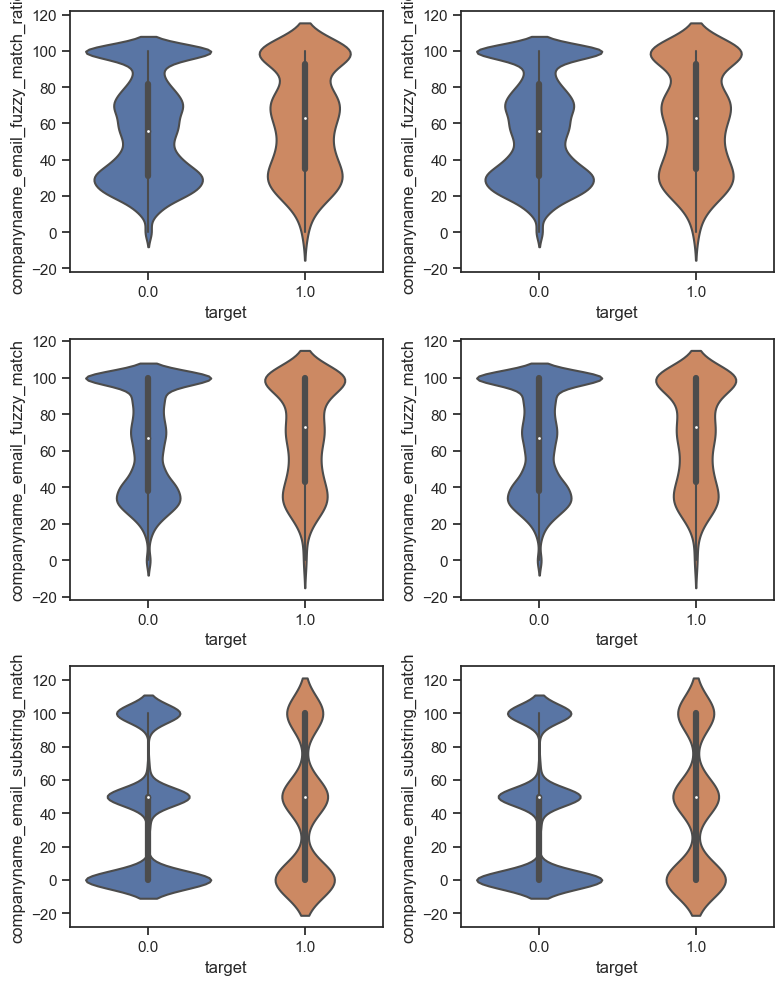

In [113]:
hue_col = 'target'

f, axes = plt.subplots(len(companyname_email_match),2, figsize=(8, 10), sharex=False)
for i, col in enumerate(companyname_email_match):
    sns.violinplot(y=col, x=hue_col, orient='v', data=df, ax=axes[i,0])
    
    # Capping upper and lower limits using IQR whiskers
    upper_limit = float(df[col].quantile([0.75]).values + 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
    lower_limit = float(df[col].quantile([0.25]).values - 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
    df_tmp = df[(df[col]<=upper_limit) & (df[col]>=lower_limit)].reset_index(drop=True)
    
    sns.violinplot(y=col, x=hue_col, orient='v', data=df_tmp, ax=axes[i,1])
    
plt.tight_layout()


In [114]:
# random email id 
# f7adf4a9-4476-429f-a686-45462c2f759f	

In [115]:
df[df['company_name']!=df['ownername']][['company_name', 'ownername']]

company_name                      ownername
0            Jeffrey Bowman            Jeffrey Dean Bowman
4               Renee Ranzy             Renee Angela Ranzy
5              Laura Whales                 Laura V Whales
7            Arthur Nicholl               Arthur f Nicholl
9             Bradley Brown                Bradley M Brown
...                     ...                            ...
20622  Rocio Patricio Ortiz  Rocio veronica Patricio Ortiz
20623          Shelby Busby            Shelby Brooke Busby
20625         Todd Schryver           Todd Albert Schryver
20626    Angelique Gallegos      Angelique LaShae Gallegos
20627   Rhoderick Manhattan         Rhoderick J. Manhattan

[8622 rows x 2 columns]

iovation_device_ip

In [116]:
def ip_address_split(val:str):
    if val==None or val=='':
        return None
    else:
        if len(val)<=15:
            val_split = val.split('.')
            if 0<=int(val_split[0])<=127:
                class_val = 'a'
            elif 128<=int(val_split[0])<=191:
                class_val = 'b'
            elif 192<=int(val_split[0])<=223:
                class_val = 'c'
            elif 224<=int(val_split[0])<=239:
                class_val = 'd'
            elif 240<=int(val_split[0])<=255:
                class_val = 'e'
            else:
                class_val = 'na'
            return class_val
        else:
            return None


In [117]:
col = 'iovation_device_ip'
df['ip_class'] = df[col].apply(ip_address_split)

In [118]:
col = 'ip_class'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['percent'], ascending=False)

ip_class  count  target  target_rate   percent
0        a  13174   465.0     0.035297  0.640416
1        b   6771   276.0     0.040762  0.329153
2        c    626    21.0     0.033546  0.030431

business_pitch

In [119]:
def extract_readability_features(text):
    if text==None or text=='':
        return_features = {'flesch_reading_ease': None, 'smog_index': None, 'flesch_kincaid_grade': None, 'coleman_liau_index': None, 
                           'automated_readability_index': None, 'dale_chall_readability_score': None, 'difficult_words': None,
                           'linsear_write_formula': None, 'gunning_fog': None, 'text_standard': ''}
        return_features = tuple(return_val.values())
    
    else:
        return_features = {
            'flesch_reading_ease': textstat.flesch_reading_ease(text),
            'smog_index': textstat.smog_index(text),
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'coleman_liau_index': textstat.coleman_liau_index(text),
            'automated_readability_index': textstat.automated_readability_index(text),
            'dale_chall_readability_score': textstat.dale_chall_readability_score(text),
            'difficult_words': textstat.difficult_words(text),
            'linsear_write_formula': textstat.linsear_write_formula(text),
            'gunning_fog': textstat.gunning_fog(text),
            'text_standard': textstat.text_standard(text)
        }
        return_features = tuple(return_features.values())
        
    return return_features


In [120]:
col = 'business_pitch'
readability_columns = ['flesch_reading_ease', 'smog_index', 'flesch_kincaid_grade', 'coleman_liau_index', 'automated_readability_index',
                       'dale_chall_readability_score', 'difficult_words', 'linsear_write_formula', 'gunning_fog', 'text_standard']
df[readability_columns] = pd.DataFrame(df[col].apply(extract_readability_features).tolist(),index=df.index)

In [121]:
col = 'text_standard'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['text_standard'], ascending=False)

text_standard  count  target  target_rate   percent
42     9th and 10th grade   2068    71.0     0.034333  0.100247
41      8th and 9th grade   2097    79.0     0.037673  0.101653
40      7th and 8th grade   2256    87.0     0.038564  0.109361
39      6th and 7th grade   1741    70.0     0.040207  0.084396
38      5th and 6th grade   1762    82.0     0.046538  0.085414
37    53rd and 54th grade      1     0.0     0.000000  0.000048
36      4th and 5th grade   1152    57.0     0.049479  0.055844
35    40th and 41st grade      1     0.0     0.000000  0.000048
34      3rd and 4th grade    997    46.0     0.046138  0.048330
33    38th and 39th grade      3     0.0     0.000000  0.000145
32    36th and 37th grade      2     0.0     0.000000  0.000097
31    35th and 36th grade      2     0.0     0.000000  0.000097
30    34th and 35th grade      2     0.0     0.000000  0.000097
29    33rd and 34th grade      3     0.0     0.000000  0.000145
28    32nd and 33rd grade      1     0.0     0.000000  0.000048
27  325th and 326th grade      1     0.0     0.000000  0.000048
26    31st and 32nd grade      3     0.0     0.000000  0.000145
25    30th and 31st grade      1     0.0     0.000000  0.000048
24      2nd and 3rd grade    473    27.0     0.057082  0.022929
23    29th and 30th grade      6     0.0     0.000000  0.000291
22    28th and 29th grade      6     0.0     0.000000  0.000291
21    27th and 28th grade      8     0.0     0.000000  0.000388
20    26th and 27th grade      7     0.0     0.000000  0.000339
19    25th and 26th grade     13     0.0     0.000000  0.000630
18    24th and 25th grade     17     1.0     0.058824  0.000824
17    23rd and 24th grade     23     0.0     0.000000  0.001115
16    22nd and 23rd grade     30     0.0     0.000000  0.001454
15    21st and 22nd grade     50     1.0     0.020000  0.002424
14    20th and 21st grade     97     2.0     0.020619  0.004702
13      1st and 2nd grade    166     8.0     0.048193  0.008047
12    19th and 20th grade    118     5.0     0.042373  0.005720
11    18th and 19th grade    150     3.0     0.020000  0.007271
10    17th and 18th grade    215     8.0     0.037209  0.010422
9     16th and 17th grade    284    10.0     0.035211  0.013767
8     15th and 16th grade    389    12.0     0.030848  0.018857
7     14th and 15th grade    602    21.0     0.034884  0.029182
6     13th and 14th grade    782    22.0     0.028133  0.037908
5     12th and 13th grade   1235    37.0     0.029960  0.059867
4     11th and 12th grade   1769    50.0     0.028265  0.085753
3     10th and 11th grade   1827    53.0     0.029009  0.088565
2       0th and 1st grade     56     2.0     0.035714  0.002715
1     -2th and -1th grade      2     0.0     0.000000  0.000097
0      -1th and 0th grade    211    11.0     0.052133  0.010228

In [122]:
text_standard_vals = list(set(df['text_standard'].values))
text_standard_vals.sort()

text_standard_vals_replace = [0, -1, 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3, 31, 32, 326, 
                              33, 34, 35, 36, 37, 39, 4, 41, 5, 54, 6, 7, 8, 9, 10]
text_standard_vals_replace = [x + 1 for x in text_standard_vals_replace]
df['text_standard_ordinals'] = df['text_standard'].replace(text_standard_vals, text_standard_vals_replace)

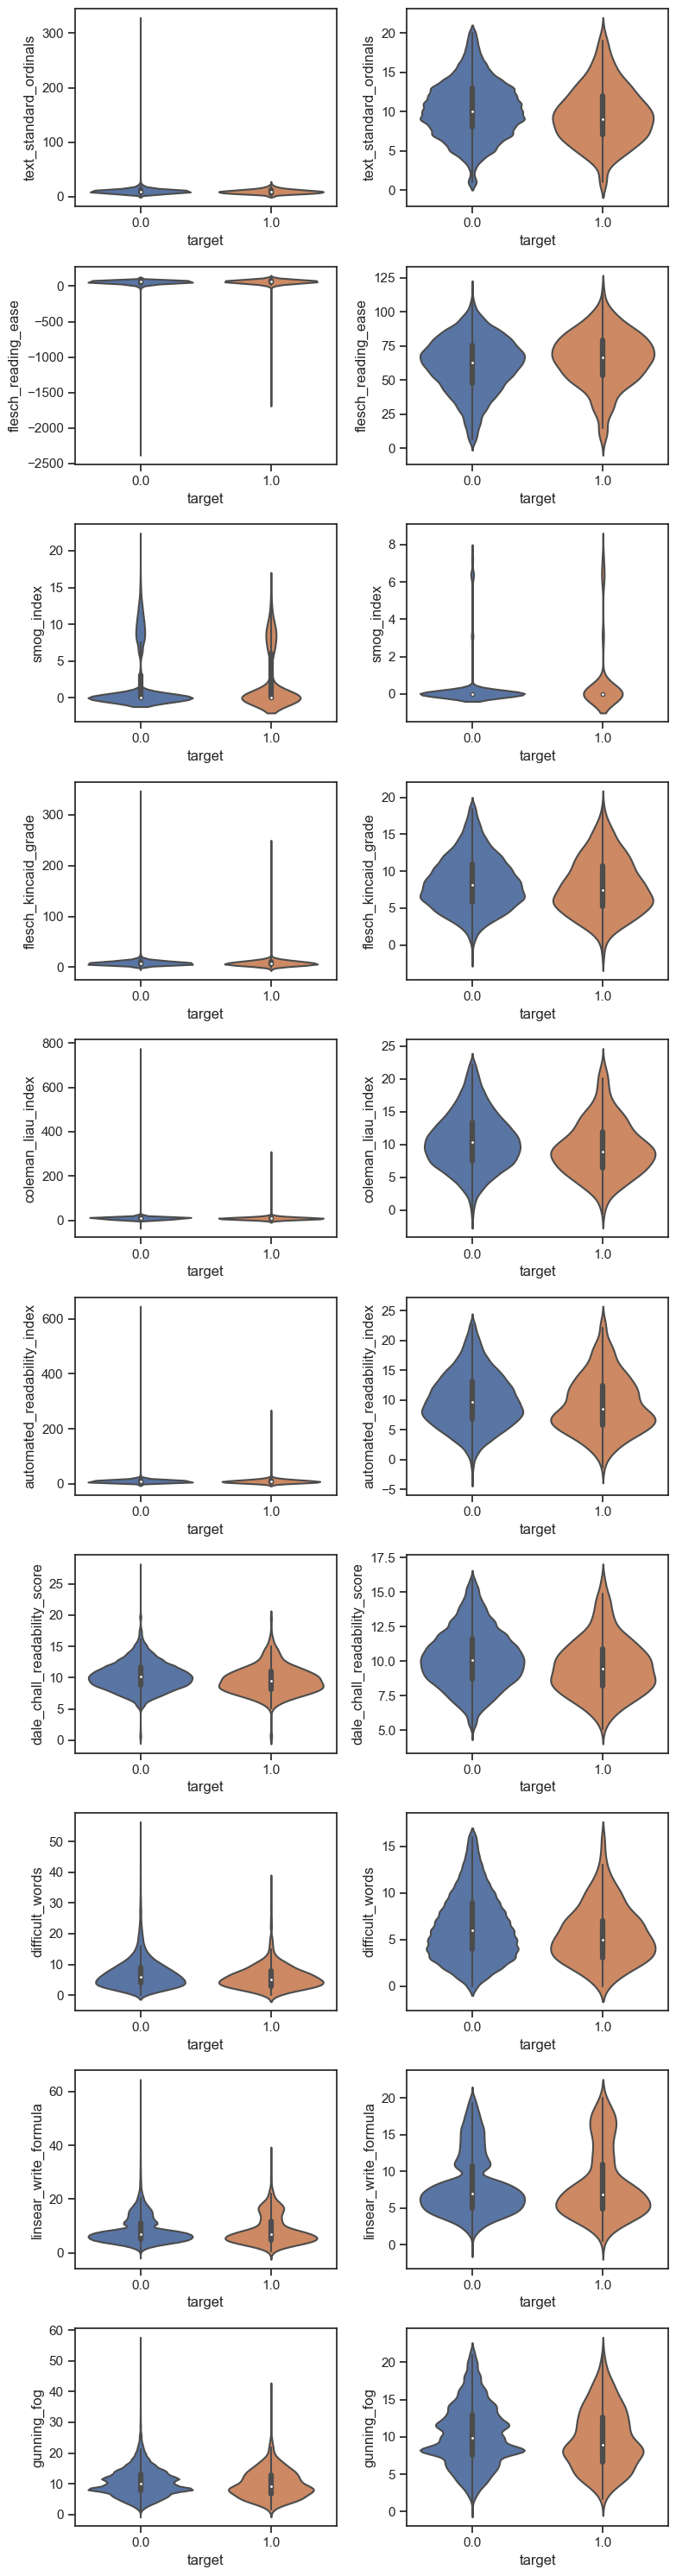

In [123]:
hue_col = 'target'

f, axes = plt.subplots(len(readability_columns),2, figsize=(8, 30), sharex=False)
for i, col in enumerate(['text_standard_ordinals']+readability_columns):
    if col != 'text_standard':
        sns.violinplot(y=col, x=hue_col, orient='v', data=df, ax=axes[i,0])
        
        # Capping upper and lower limits using IQR whiskers
        upper_limit = float(df[col].quantile([0.75]).values + 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
        lower_limit = float(df[col].quantile([0.25]).values - 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
        df_tmp = df[(df[col]<=upper_limit) & (df[col]>=lower_limit)].reset_index(drop=True)
        
        sns.violinplot(y=col, x=hue_col, orient='v', data=df_tmp, ax=axes[i,1])
        
plt.tight_layout()


In [124]:
df['text_standard_levels'] = np.where(df['text_standard'].isin(['6th and 7th grade','7th and 8th grade','8th and 9th grade', '9th and 10th grade']
                                               ), 'l2', (np.where(df['text_standard'].isin(['-1th and 0th grade','0th and 1st grade','1st and 2nd grade','2nd and 3rd grade','3rd and 4th grade',
                                                                                            '4th and 5th grade','5th and 6th grade']), 'l1', 'l3'))
                      )

In [125]:
col = 'text_standard_levels'
tmp1 = pd.DataFrame(df.groupby([col])['target'].agg(['count', 'sum', 'mean'])).reset_index().rename(columns={'sum':'target',
                                                                                                             'mean':'target_rate'})
tmp2 = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index().rename(columns={'index':col , col:'percent'})
tmp = tmp1.merge(tmp2, on=col, how='inner')
tmp.sort_values(by=['target_rate'], ascending=False)

text_standard_levels  count  target  target_rate   percent
0                   l1   4817   233.0     0.048370  0.233506
1                   l2   8162   307.0     0.037613  0.395657
2                   l3   7650   225.0     0.029412  0.370837

In [140]:
# Linguistic features
def extract_linguistic_features(text):
   
    if text==None or text=='':
        return (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
    else:
        # print(text,'\n\n')
        words = nltk.word_tokenize(text)
        sentences = nltk.sent_tokenize(text)
        syllable_count = sum(textstat.syllable_count(word) for word in words)
        polysyllable_count = len([word for word in words if textstat.syllable_count(word) >= 3])
        pos_tags = nltk.pos_tag(words)
        pos_counts = Counter(tag for word, tag in pos_tags)

        blob = TextBlob(text)
        analyzer = SentimentIntensityAnalyzer()
        vader_sentiment = analyzer.polarity_scores(text)
    
        linguistic_features = {
            'total_word_count': len(words),
            'sentence_count': len(sentences),
            'average_sentence_length': len(words) / len(sentences),
            'average_word_length': sum(len(word) for word in words) / len(words),
            'syllable_count': syllable_count,
            'polysyllable_count': polysyllable_count,
            'unique_words_count': len(set(words)),
            'type_token_ratio': len(set(words)) / len(words),
            'lexical_density': sum(1 for tag in pos_tags if tag[1] in ['NN', 'VB', 'JJ', 'RB']) / len(words),
            'pos_counts': pos_counts,
            
            'textblob_polarity': blob.sentiment.polarity, 
            'textblob_subjectivity': blob.sentiment.subjectivity,
            'vader_neg': vader_sentiment['neg'],
            'vader_neu': vader_sentiment['neu'],
            'vader_pos': vader_sentiment['pos'],
            'vader_compound': vader_sentiment['compound']
        }
        linguistic_features = tuple(linguistic_features.values())
        
        return linguistic_features
        

In [135]:
# def remove_stopwords_spacy(text):
#     doc = nlp(text)
#     filtered_text = [token.text for token in doc if not token.is_stop]
#     return ' '.join(filtered_text)

# doc = nlp(df['business_pitch'][i])
# filtered_text = [token.text for token in doc if not token.is_stop]
# text2 = ' '.join(filtered_text)
# words = nltk.word_tokenize(text2)
# pos_tags = nltk.pos_tag(words)
# pos_counts = Counter(tag for word, tag in pos_tags)

In [136]:
# tt = df['pos_counts'].apply(pd.Series)
# tt['target'] = df.target

In [137]:
# tt.groupby(['PRP'])['target'].agg(['count', 'sum', 'mean'])

In [138]:
# pos_columns = ['PRP','VBP','JJ','NN','NNS','TO','IN','NNP','VBG','RB','VB','CC']
# tt = pd.json_normalize(df['pos_counts'])

In [141]:
col = 'business_pitch'
linguistic_columns = ['total_word_count','sentence_count','average_sentence_length','average_word_length','syllable_count',
                      'polysyllable_count','unique_words_count','type_token_ratio','lexical_density','pos_counts',
                      'textblob_polarity','textblob_subjectivity','vader_neg','vader_neu','vader_pos','vader_compound']
df[linguistic_columns] = pd.DataFrame(df[col].apply(extract_linguistic_features).tolist(),index=df.index)

In [143]:
# df_tmp = df.copy(deep=True)

In [144]:
# exploding POS tags and creating important columns
pos_tags_columns = ['PRP','VBP','JJ','NN','NNS','TO','IN','NNP','VBG','RB','VB','CC']
df = pd.concat([df,pd.json_normalize(df['pos_counts'])[pos_tags_columns].fillna(0)], axis=1)

In [148]:
df.shape

(20629, 345)

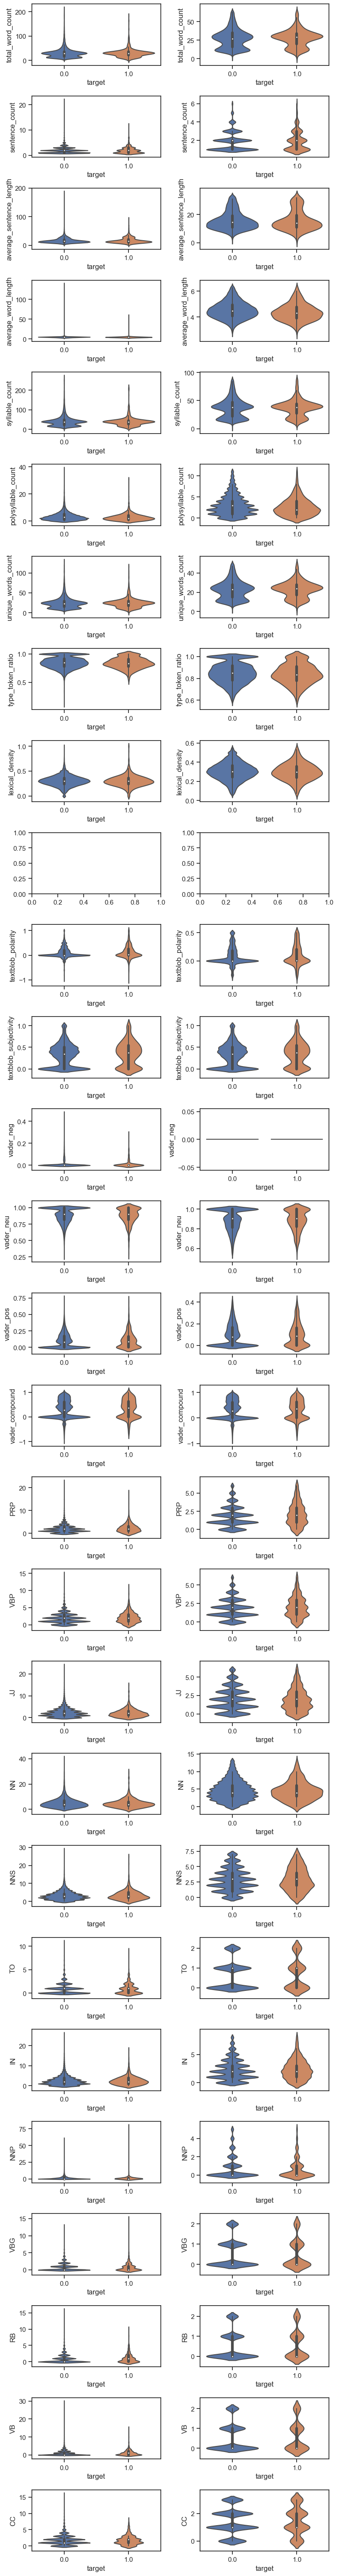

In [152]:
hue_col = 'target'

f, axes = plt.subplots(len(linguistic_columns+pos_tags_columns),2, figsize=(8, 60), sharex=False)
for i, col in enumerate((linguistic_columns+pos_tags_columns)):
    if col != 'pos_counts':
        sns.violinplot(y=col, x=hue_col, orient='v', data=df, ax=axes[i,0])
        
        # Capping upper and lower limits using IQR whiskers
        upper_limit = float(df[col].quantile([0.75]).values + 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
        lower_limit = float(df[col].quantile([0.25]).values - 1.5*(df[col].quantile([0.75]).values - df[col].quantile([0.25]).values))
        df_tmp = df[(df[col]<=upper_limit) & (df[col]>=lower_limit)].reset_index(drop=True)
        
        sns.violinplot(y=col, x=hue_col, orient='v', data=df_tmp, ax=axes[i,1])
        
plt.tight_layout()


In [ ]:
col = 'website'
df[col].value_counts()

In [ ]:
df_tmp[df_tmp[col]=='Asquadcoach.com'][['email','company_name','industry_supercategory_from_pitch', 'industry_category_name', 'business_pitch']]

In [ ]:
cat_columns

In [ ]:
df['test'] = np.where(df[col].isnull(), 0, 1)

In [ ]:
df.groupby(['test'])['target'].agg(['count','sum', 'mean'])

In [ ]:
df[(df.target==1) & (~df.website.isnull())][[col, 'company_name', 'email', 'owner_list']]

Mapping the pandas data types to numpy data types

In [ ]:
data_type_dict = df.dtypes.astype(str).to_dict()
data_type_mapping = {'float64':np.float64,'object':object,'bool':bool,'int64':np.int64}
data_type_dict = {k: data_type_mapping[v] for k, v in data_type_dict.items() if v in data_type_mapping}

Converting few default data types to correct data types

In [ ]:
data_type_dict['iovation_proxy_in_use'] = bool
data_type_dict['iovation_timezone_geolocation_mismatch'] = bool
data_type_dict['is_email_valid'] = bool
data_type_dict['ein_ssn'] = bool

Apply data type changes to the datarame

In [ ]:
df = df.astype(data_type_dict)

In [ ]:
df[['number_of_employees']] = df[['number_of_employees']].apply(pd.to_numeric)

In [ ]:
drop_cols_more = ['business_id', 'application_id.1', 'application_id.2', 'client_ip', 'touch_point_emails', 'touch_point_full_names', 
                  'app_tags_sorted', 'application_notes', 'business_type.1', 'pred_prob', 'nsl_current', 'flow', 
                  'is_api_based_partner_application', 'industry_category_from_pitch', 'industry_supercategory_from_pitch',
                  'owner_list', 'application_risks_total_risk', 'onboarding_flow', 'phone', 'device']
df = df.drop(columns=drop_cols_more)

#### Feature Engineering thoughts

- higher emplyees should correlate with financial high numbers
- application time/day started
  - convert days into ideal and non ideal groups
  - convert time into ideal and non ideal groups
- application time/day started
  - convert days into ideal and non ideal groups
  - convert time into ideal and non ideal groups
- use all the IP features to derive new features
- create flags if IP location matches with business address
- check if phone can be used to derive flags in relation with the business address or IP
- website response flag
- convert website into groups like social, personal, ecommerce, portfolio, small businesses, blogs
- create feature by checking the name/company name in the email
- create feature by checking the name/company name in the email
- use the KYC/Fraud flags to create new features
- check app hour groups into loss amount correlation
- age of the owner
- gender of the owner
- risk status of the city or region

In [157]:
df[accounts_cols+['number_of_employees','application_id']]

estimated_monthly_revenue incoming_ach_payments check_deposit_amount  \
0                       upto_1k               upto_1k              upto_1k   
1                       1k_plus               1k_plus              1k_plus   
2                       1k_plus               1k_plus              upto_1k   
3                       1k_plus               1k_plus              1k_plus   
4                       1k_plus               1k_plus              upto_1k   
...                         ...                   ...                  ...   
20624                   upto_1k               upto_1k              upto_1k   
20625                   upto_1k               upto_1k              upto_1k   
20626                   1k_plus               1k_plus              1k_plus   
20627                   1k_plus               1k_plus              upto_1k   
20628                   1k_plus               1k_plus              1k_plus   

      incoming_wire_transfer outgoing_ach_and_checks outgoing_wire_transfers  \
0                    upto_1k                 upto_1k                 upto_1k   
1                    upto_1k                 upto_1k                 upto_1k   
2                    1k_plus                 upto_1k                 upto_1k   
3                    1k_plus                 1k_plus                 1k_plus   
4                    upto_1k                 1k_plus                 1k_plus   
...                      ...                     ...                     ...   
20624                upto_1k                 upto_1k                 upto_1k   
20625                upto_1k                 upto_1k                 upto_1k   
20626                1k_plus                 1k_plus                 1k_plus   
20627                1k_plus                 1k_plus                 1k_plus   
20628                1k_plus                 1k_plus                 1k_plus   

       number_of_employees                        application_id  
0                      1.0  4862a1eb-6f55-4a2a-84ca-fe212d6fc504  
1                      4.0  c5938c50-f34d-4e6d-b352-2fc8e02c7371  
2                      1.0  16c28e2e-728f-4b2b-86d8-543a44a1884a  
3                      3.0  21dd7f9b-286a-4956-b8ec-2c45d1024477  
4                      3.0  9a07f070-107a-4536-a07a-8ca535e7cfaf  
...                    ...                                   ...  
20624                  1.0  e8862300-e88b-49d2-814a-e3632fb572a0  
20625                 10.0  cb863305-ddd8-488f-b7fc-1b3c50bf7e6f  
20626                  1.0  e2db4338-3304-4430-a54d-eae0faeed49d  
20627                  3.0  58972ee0-6e79-425b-b17b-4bec6aa063cd  
20628                  4.0  81881549-b41e-4679-ab20-ceb9372899b7  

[20629 rows x 8 columns]

In [159]:
x_train[x_train.application_id=='cb863305-ddd8-488f-b7fc-1b3c50bf7e6f'][accounts_cols+['number_of_employees','target']]

estimated_monthly_revenue incoming_ach_payments check_deposit_amount  \
29465                      <$1K                  <$1K                 <$1K   

      incoming_wire_transfer outgoing_ach_and_checks outgoing_wire_transfers  \
29465                   <$1K                    <$1K                    <$1K   

       number_of_employees  target  
29465                 10.0     0.0